# Imports

In [ ]:
!pip install tensorflow
import pandas as pd
from scipy.interpolate import interp1d
from scipy .integrate import cumulative_trapezoid
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential, Model
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback
from keras import Loss
from keras.saving import custom_object_scope
import seaborn as sns

# Train on single vehicle dynamics

## Constant coefficient car

In [12]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate
        self.x0 = x0
        self.X = np.array(self.x0, dtype=np.float32) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }

        self.dX_hist = [(0.0, 0.0)]

    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""

        # Store history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)


        # runge-kutta
        # k1 = self._dynamics(self.X, u)
        # a = k1[1] #gets v_dot = actual acceleration
        # self.history["a"].append(a)

        # k2 = self._dynamics(self.X + 0.5*dt*k1, u)
        # k3 = self._dynamics(self.X + 0.5*dt*k2, u)
        # k4 = self._dynamics(self.X + dt*k3, u)

        # self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        # self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        # self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

        dX_prev = self.dX_hist[-1]
        dX = self._dynamics(self.X, u)
        self.dX_hist.append(dX)

        self.history["a"].append(dX[1])
        #trapezoid integral step:
        self.X[0] += (dX[0]+dX_prev[0])*dt/2
        self.X[1] += (dX[1]+dX_prev[1])*dt/2

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)

        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        #return np.array([v,a])
        return (v, a)

    def reset(self, x0):
        del self.history
        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }
        self.X = np.array(x0, dtype=np.float32) #[position, velocity]
        self.dX_hist = [(0.0, 0.0)]


## Generate synthetic data

   traj_id    t      u    a_meas    a_true   v_true_m  v_true_km    x_true
0      0.0  0.0  510.0 -0.003047 -0.000861  13.888889  50.000000  0.000000
1      0.0  0.1  510.0 -0.008493 -0.000861  13.888846  49.999847  0.694444
2      0.0  0.2  510.0 -0.008632 -0.000860  13.888761  49.999538  2.083331
3      0.0  0.3  510.0  0.017634 -0.000860  13.888675  49.999229  3.472212
4      0.0  0.4  510.0 -0.007915 -0.000859  13.888589  49.998920  4.861084


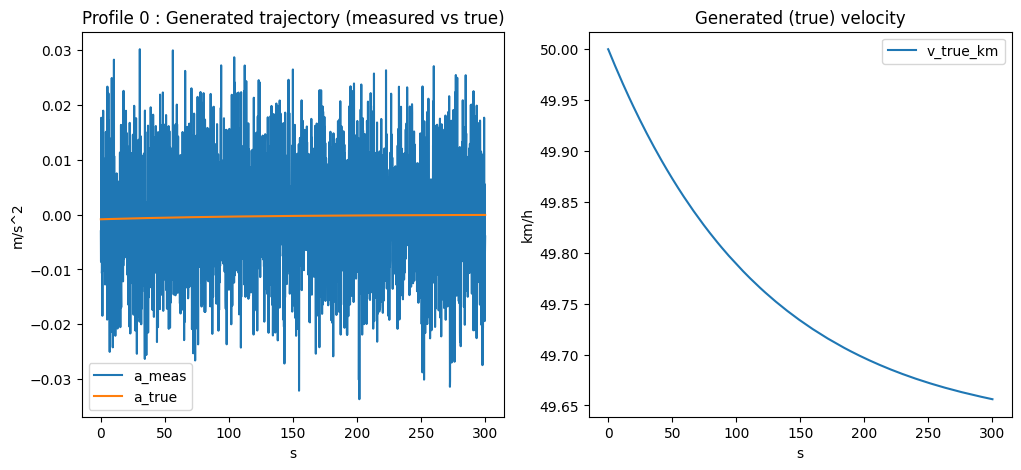

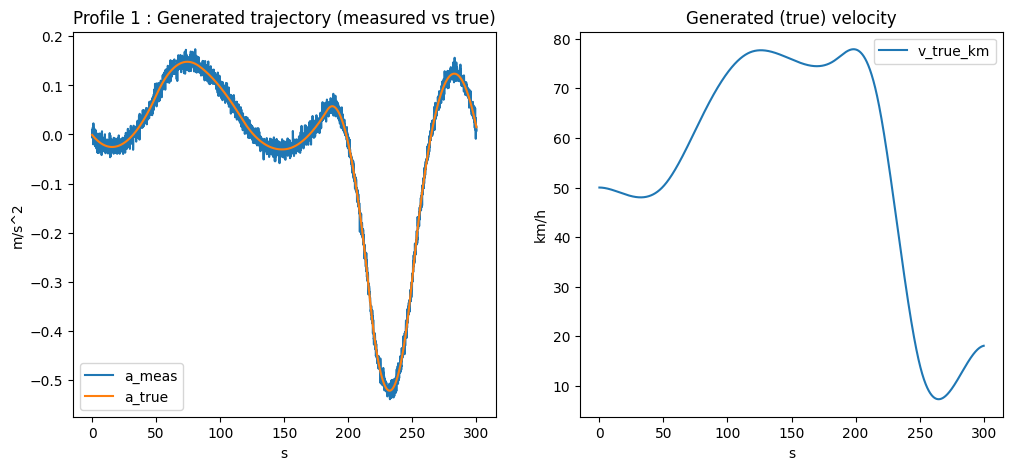

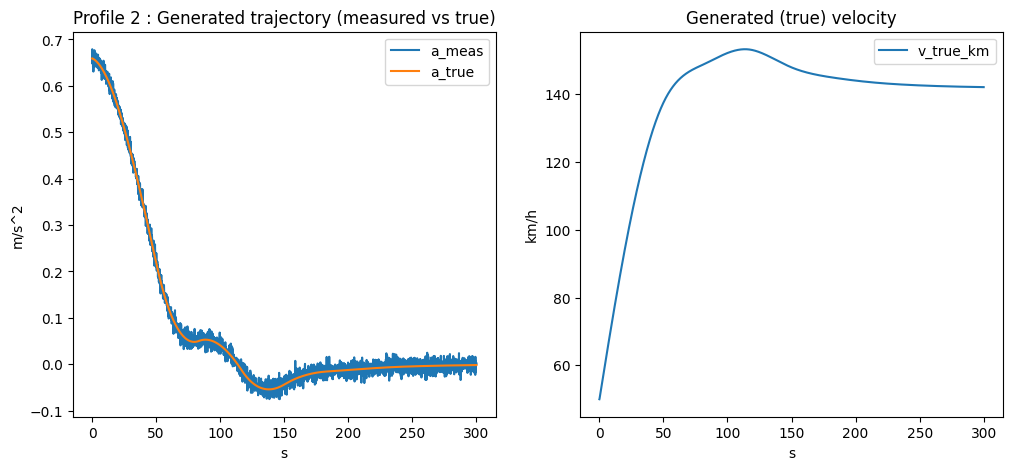

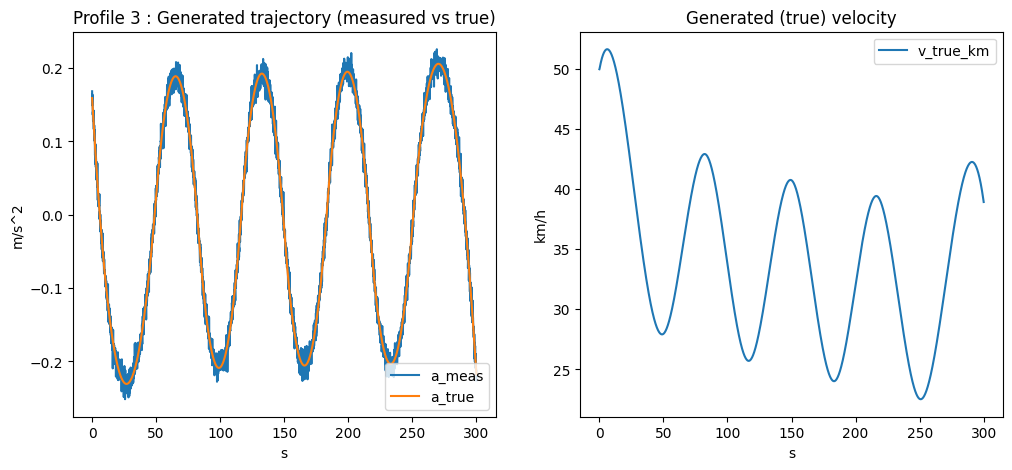

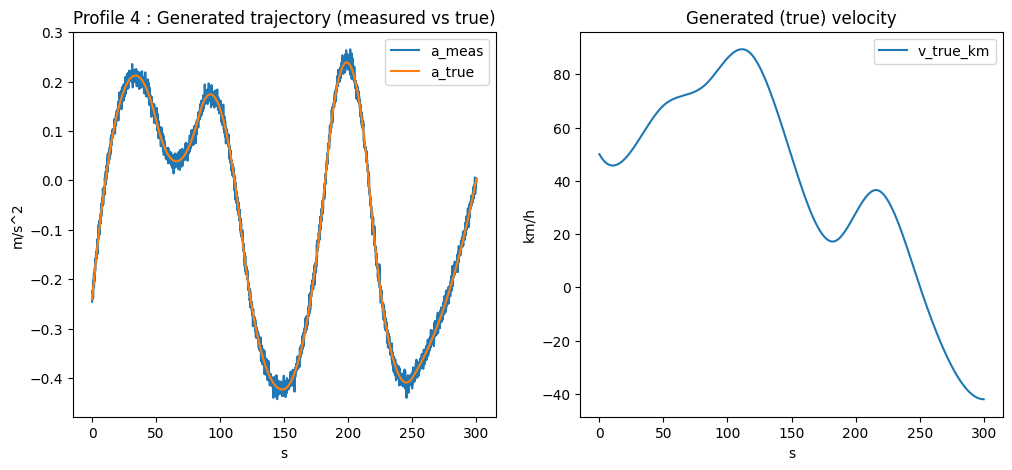

In [13]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
v0 = 50/3.6
x0 = (0, v0) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)
t_samp = np.linspace(0, t_end, 10, dtype=np.float32)
std = 1e-2

#DEFINE U PROFILES
input_profiles = []
input_profiles.append(np.full_like(t_samp, 0.34, dtype=np.float32) * m) #crusing
input_profiles.append(np.array([0.34, 0.34, 0.5, 0.5, 0.4, 0.4, 0.4, -0.2, 0.3, 0.3], dtype=np.float32) * m) #emerg braking
input_profiles.append(np.array([1.0, 1.0, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7], dtype=np.float32) * m) #accelerating
input_profiles.append(np.array([0.5, 0.1]*5, dtype=np.float32) * m) #stop&go/oscillating
np.random.seed(31)
input_profiles.append(np.random.uniform(low=-0.1, high=0.6, size=t_samp.shape).astype(np.float32) * m) #random

input_interp = []
for profile in input_profiles:
    input_interp.append(interp1d(t_samp, profile, kind='quadratic'))

#simulate and build dataframes
def simulate_traj(car, u_func, traj_id, t):
    for t_curr in t:
        car.update(u_func(t_curr), dt)
    data = {
        'traj_id': traj_id,
        't': t,
        'u': car.history["u"],
        'a_meas': np.array(car.history["a"]) + np.random.normal(loc=0, scale=std, size=len(t)),
        'a_true': car.history["a"],
        'v_true_m': car.history["v"],
        'v_true_km': np.array(car.history["v"])*3.6,
        'x_true': car.history["x"],
    }

    return pd.DataFrame(data, dtype=np.float32)

dataframes = []
for id, func in enumerate(input_interp):
    dataframe = simulate_traj(car, func, id, t)

    #plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    dataframe.plot(x='t', y=["a_meas", "a_true"], ax=axs[0],
               title="Profile " + str(id) + " : Generated trajectory (measured vs true)",
               legend=True, ylabel="m/s^2", xlabel="s")
    dataframe.plot(x='t', y="v_true_km", ax=axs[1],
               title="Generated (true) velocity",
               legend=True, ylabel="km/h", xlabel="s")

    dataframes.append(dataframe)
    car.reset(x0) #x0 common for all trajectories

dataset = pd.concat(dataframes, axis=0, ignore_index=True)
dataset.to_csv("data/synthetic_5_trajectories.csv", index=False)
print(dataset.head())

## Helper funcs

In [14]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str, meas_data: np.ndarray = None):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''

    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12, 8))
    plt.suptitle(suptitle)

    # Plot for acceleration:
    plt.subplot(1, 3, 1)
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    if meas_data is not None:
        plt.scatter(t, meas_data, label="Measured acceleration points", s=7)
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Acceleration")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1, 3, 2)
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()


    plt.subplot(1, 3, 3)
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    stopped_epoch = np.argmin(val_loss) + 1  # Get the epoch with the minimum validation loss

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    # Add a marker for the early stopping epoch
    plt.axvline(x=stopped_epoch, color='r', linestyle='--', label='Early Stopping')
    plt.text(stopped_epoch, val_loss[stopped_epoch - 1], f'({stopped_epoch}, {val_loss[stopped_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

def evaluate_results(model, X_norm, true_data):
    v = np.zeros_like(t)
    x = np.zeros_like(t)

    pred_a = model.predict(X_norm)
    v = cumulative_trapezoid(y=pred_a.flatten(), dx=dt, initial=0)  # Velocity (m/s)
    v += x0[1]
    x = cumulative_trapezoid(y=v, dx=dt, initial=0)
    x += x0[0]

    mse_a = mean_squared_error(true_data[:, 0], pred_a)
    mse_v = mean_squared_error(true_data[:, 1], v)
    mse_x = mean_squared_error(true_data[:, 2], x)

    v = v.reshape(-1, 1)
    x = x.reshape(-1, 1)

    pred_data = np.hstack((pred_a, v, x))

    print(f"MSE/RMSE for acceleration: {mse_a:.5e}, {np.sqrt(mse_a):.5e}")
    print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
    print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

    return pred_data

# Prepping data

**for now only using one of the trajectories for training although I had made a tf.dataset that would have shape (traj, N, features) for parallel training. But that would require changing the models architecture as far as I know for now. Stash that**

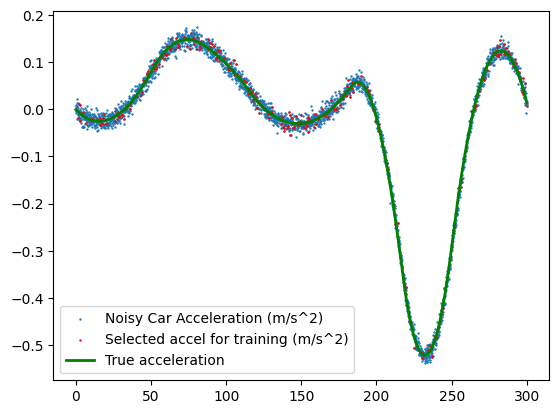

' # Plot histograms for features and outputs using seaborn\nfig, ax = plt.subplots(1, 2, figsize=(12, 5))\nfig.suptitle("After normalization")\n\n# Plot histograms for features\nsns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=ax[0], color=\'blue\')\nax[0].set_title(\'Histogram of Feature t (training)\')\nax[0].set_xlabel(\'t\')\nax[0].set_ylabel(\'Frequency\')\n\nsns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=ax[1], color=\'green\')\nax[1].set_title(\'Histogram of Feature u (training)\')\nax[1].set_xlabel(\'u\')\nax[1].set_ylabel(\'Frequency\')\n\n# Plot histogram for output\nplt.figure(figsize=(6, 5))\nsns.histplot(Y_train, bins=100, kde=True, color=\'orange\')\nplt.title(\'Histogram of Acceleration (training)\')\nplt.xlabel(\'Acceleration\')\nplt.ylabel(\'Frequency\')\n\nplt.tight_layout()\nplt.show() '

In [15]:
train_ratio = .1 #data sparsity
train_id = 1 #traj id
test_id = 3

df_train_traj = dataset[dataset['traj_id'] == train_id]
df_test_traj = dataset[dataset['traj_id'] == test_id]
X = df_train_traj[["t", "u", "v_true_m", "x_true"]].to_numpy() #control input + states + time dependency -> shape 4, N
X_test = df_test_traj[["t", "u", "v_true_m", "x_true"]].to_numpy() #control input + states + time dependency -> shape 4, N

Y_noise = df_train_traj[["a_meas"]].to_numpy() #shape N, 1
Y_true = df_train_traj[["a_true"]].to_numpy() #shape N, 1
Y_test = df_test_traj[["a_true"]].to_numpy()

Y_train, Y_val, X_train, X_val = train_test_split(Y_noise, X, train_size=train_ratio, random_state=31)
#print(Y_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(Y_noise, Y_train)
Y_mask = Y_noise.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_noise, label="Noisy Car Acceleration (m/s^2)", s=.5)
plt.scatter(t, Y_mask, label="Selected accel for training (m/s^2)", s=.5, color="red")
plt.plot(t, Y_true, label="True acceleration", linewidth=2, color="green")
plt.legend()
plt.show()

""" #Prediction Normalization
# not doing this now
scaler_Y = StandardScaler().fit(Y_train)
Y_train_norm = scaler_Y.transform(Y_train)
Y_val_norm = scaler_Y.transform(Y_val)
Y_true_norm = scaler_Y.transform(Y_true)
y_0_norm = Y_true_norm[0, :] """

# feature normalization all based on the training distribution
scaler_X = MinMaxScaler().fit(X_train)
X_train_norm = scaler_X.transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)
X_norm = scaler_X.transform(X)
x0_norm = X_norm[0, :]
y0_true = Y_true[0, :]

""" # Plot histograms for features and outputs using seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("After normalization")

# Plot histograms for features
sns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Histogram of Feature t (training)')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Frequency')

sns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=ax[1], color='green')
ax[1].set_title('Histogram of Feature u (training)')
ax[1].set_xlabel('u')
ax[1].set_ylabel('Frequency')

# Plot histogram for output
plt.figure(figsize=(6, 5))
sns.histplot(Y_train, bins=100, kde=True, color='orange')
plt.title('Histogram of Acceleration (training)')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show() """

# PUNN-only

In [16]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 150
start_from_epoch = 200
loss = "mse"
metrics = []
schedule_tg = 100
opt = Adam(learning_rate=1e-4, weight_decay=1e-3)
batch = 16
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)
def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/punn_model_forward.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(n_features, ))) #_ for batch dim
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(1, activation="linear")) #output layer -> a^

punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
punn_model.summary()

history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train, validation_data=(X_val, Y_val),
                                  batch_size=batch, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history)

I0000 00:00:1744292323.039928   61447 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1989 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


KeyboardInterrupt: 

In [ ]:
punn_model.save("models/punn_model_forward.h5")

## PUNN predictions
offline integration for testing, in reality it would be real-time

## Training trajectory

In [ ]:
true_data = df_train_traj[["a_true", "v_true_m", "x_true"]].to_numpy()
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
print("Training trajectory (" + str(train_id) + ") statistics: ")
punn_train_traj_eval = evaluate_results(model=punn_model, X_norm=X_norm, true_data=true_data)
print("----")
comparison_plot(t=t, true_data=true_data, meas_data=Y_mask,
    pred_data=[(punn_train_traj_eval, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory " + str(train_id)
)


## Testing trajectory (generalization ability)

In [ ]:
true_data_test = df_test_traj[["a_true", "v_true_m", "x_true"]].to_numpy()
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
print("Testing trajectory (" + str(test_id) + ") statistics: ")
punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=X_test_norm, true_data=true_data_test)
print("----")
comparison_plot(t=t, true_data=true_data_test, meas_data=None,
    pred_data=[(punn_test_traj_eval, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory" + str(test_id)
)

# PINN

## Combined Loss

In [17]:
#not using this now
# def tf_cumulative_trapezoid(y, x):
#     """
#     Computes cumulative integral using the trapezoidal rule without breaking tensor computational graph
#     Both y and x must be 1D tensors of the same length.
#     """
#     dx = x[1:] - x[:-1]
#     areas = 0.5 * (y[1:] + y[:-1]) * dx
#     return tf.concat([[0.0], tf.math.cumsum(areas)], axis=0)


In [18]:
collocation_size = int(len(t)/4)
print("Number of collocation points: " + str(collocation_size))
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = input_interp[train_id] #get u from correct trajectory function
car.reset(x0)
df_c = simulate_traj(car=car, u_func=u_c, traj_id=train_id, t=t_c)
df_c.to_csv("data/train_traj_collocation.csv")
X_c = df_c[["t", "u", "v_true_m", "x_true"]].to_numpy()
X_c_norm = scaler_X.transform(X_c)

class PinnModel(Sequential):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        #joint training of physics params
        self.c0 = self.add_weight(name="c0", shape=(), initializer="zeros",
                        trainable=True, dtype=tf.float32) #trainable -> added to tape.watch automatically according to docs
        self.c1 = self.add_weight(name="c1", shape=(), initializer="zeros",
                        trainable=True, dtype=tf.float32)
        self.phy_trainable = {"c0": self.c0, "c1": self.c1}
        #True values: c0 = 0.0075, c1 = 2*10**-4
        self.phy_trainable_true = {"c0": c0, "c1": c1}

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y0: np.ndarray, x0_norm: np.ndarray,
                 scaler_X: MinMaxScaler, loss_weights: tuple[float, float, float], scaler_Y=None):
        super().__init__()

        self.car = car
        self.model = model
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights

        #IC
        self.y0 = y0 #acc
        #self.v0 = v0
        self.x0_norm = x0_norm
        #self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X

        self.X_c_norm = tf.convert_to_tensor(X_c_norm, dtype=tf.float32)

        X_c_denorm = scaler_X.inverse_transform(X_c_norm)
        self.t_c, self.u, self.v, self.x = (tf.constant(X_c_denorm[:, i]) for i in range(X_c_denorm.shape[1]))

    def data_loss(self, y_true, y_pred):
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        g = 9.81
        car = self.car

        a = self.model(self.X_c_norm) #use PUNN to predict on collocation points
        a = tf.reshape(a, shape=([-1])) #flatten for shape matching
        #denormalize
        #a_phy = a_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ #denorm
        #a_phy = keras.ops.ravel(a_phy) #-> 1D
        #v_phy = self.v0 + tf_cumulative_trapezoid(a_phy, self.t_c) -> wrong, should use state

        #print(a.shape, sel\f.v.shape, self.u.shape, (self.v**2).shape)
        #resistive forces
        Fr = (self.model.c0 + self.model.c1 * self.v) * (car.m * g * np.cos(car.road_grade))
        Fa = (car.p * car.Cd * car.Af * self.v**2) / 2
        Fg = car.m * g * np.sin(car.road_grade)


        #physics residuals
        res = car.m * a - (self.u - Fr - Fa - Fg)  # Newton's law

        return tf.reduce_mean(tf.square(res))

    def boundary_loss(self):
        y0_pred = self.model(self.x0_norm[tf.newaxis, :]) #add batch shape
        sqr_diff = tf.square(y0_pred - self.y0)
        return tf.reduce_mean(sqr_diff)

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return (
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss +
            self.alpha_b * bound_loss
        )

Number of collocation points: 750


## Training

Epoch 1/2000


I0000 00:00:1744292346.654214   78737 service.cc:148] XLA service 0x7f83600045c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744292346.654757   78737 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-04-10 14:39:06.763973: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744292347.125883   78737 cuda_dnn.cc:529] Loaded cuDNN version 90300


11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 85959.8672 - mse: 0.0227  

I0000 00:00:1744292349.026713   78737 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 76801.2422 - mse: 0.0215

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 75882.3438 - mse: 0.0214 - val_loss: 26950.7012 - val_mse: 0.0236 - learning_rate: 0.0010 - c0: -1.3576e-04 - c1: 1.7191e-04
Epoch 2/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 19233.4922 - mse: 0.0317 - val_loss: 4783.0024 - val_mse: 0.1022 - learning_rate: 0.0010 - c0: -0.0017 - c1: -0.0012
Epoch 3/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 3034.8274 - mse: 0.1410 - val_loss: 1766.1686 - val_mse: 0.2094 - learning_rate: 0.0010 - c0: -0.0033 - c1: -0.0017
Epoch 4/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1502.7947 - mse: 0.2005 - val_loss: 786.4050 - val_mse: 0.1606 - learning_rate: 0.0010 - c0: -0.0046 - c1: -0.0013
Epoch 5/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 684.5703 - mse: 0.1576 - val_loss: 400.7415 - val_mse: 0.1486 - learning_rate: 0.0010 - c0: -0.0059 - c1: -0.0011
Epoch 6/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 334.2820 - mse: 0.1485 - val_loss: 181.2454 - val_mse: 0.14

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0909 - mse: 0.0236 - val_loss: 0.0904 - val_mse: 0.0235 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.7471e-04
Epoch 665/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0905 - mse: 0.0238

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0904 - mse: 0.0238 - val_loss: 0.0898 - val_mse: 0.0235 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.7488e-04
Epoch 666/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0901 - mse: 0.0239

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0899 - mse: 0.0238 - val_loss: 0.0892 - val_mse: 0.0234 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.7505e-04
Epoch 667/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0886 - mse: 0.0230

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - loss: 0.0887 - mse: 0.0231 - val_loss: 0.0886 - val_mse: 0.0234 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.7522e-04
Epoch 668/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0892 - mse: 0.0241

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0891 - mse: 0.0240 - val_loss: 0.0880 - val_mse: 0.0233 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.7539e-04
Epoch 669/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0880 - mse: 0.0234

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0879 - mse: 0.0234 - val_loss: 0.0874 - val_mse: 0.0233 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.7556e-04
Epoch 670/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0871 - mse: 0.0230 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0872 - mse: 0.0231 - val_loss: 0.0869 - val_mse: 0.0232 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.7573e-04
Epoch 671/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0855 - mse: 0.0220

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0860 - mse: 0.0225 - val_loss: 0.0863 - val_mse: 0.0232 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.7592e-04
Epoch 672/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0861 - mse: 0.0230 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0865 - mse: 0.0231 - val_loss: 0.1052 - val_mse: 0.0231 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.7560e-04
Epoch 673/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.0300 - mse: 0.0233 - val_loss: 302.9029 - val_mse: 0.0237 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 4.3689e-04
Epoch 674/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 565.5914 - mse: 0.0231 - val_loss: 1.0582 - val_mse: 0.0235 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.8866e-04
Epoch 675/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 62.0468 - mse: 0.0242 - val_loss: 10.8014 - val_mse: 0.0231 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 4.0262e-04
Epoch 676/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6620 - mse: 0.0241 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 8.4603 - mse: 0.0240 - val_loss: 4.5415 - val_mse: 0.0228 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.8569e-04
Epoch 677/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.8868 - mse: 0.0230 - val_loss: 0.1061 - val_mse: 0.0228 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9401e-04
Epoch 678/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2867 - mse: 0.0228

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.2734 - mse: 0.0229 - val_loss: 0.1710 - val_mse: 0.0228 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9484e-04
Epoch 679/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1311 - mse: 0.0225

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1284 - mse: 0.0225 - val_loss: 0.1015 - val_mse: 0.0227 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9442e-04
Epoch 680/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0938 - mse: 0.0221

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0931 - mse: 0.0223 - val_loss: 0.0895 - val_mse: 0.0226 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9432e-04
Epoch 681/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0885 - mse: 0.0227

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0884 - mse: 0.0227 - val_loss: 0.0871 - val_mse: 0.0226 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9434e-04
Epoch 682/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0872 - mse: 0.0228

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0872 - mse: 0.0228 - val_loss: 0.0865 - val_mse: 0.0225 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9446e-04
Epoch 683/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0860 - mse: 0.0222

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0861 - mse: 0.0223 - val_loss: 0.0858 - val_mse: 0.0225 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9466e-04
Epoch 684/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0860 - mse: 0.0228

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0859 - mse: 0.0227 - val_loss: 0.0852 - val_mse: 0.0224 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9482e-04
Epoch 685/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0848 - mse: 0.0222

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0848 - mse: 0.0222 - val_loss: 0.0846 - val_mse: 0.0224 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9498e-04
Epoch 686/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0851 - mse: 0.0229

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0850 - mse: 0.0229 - val_loss: 0.0840 - val_mse: 0.0223 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 3.9515e-04
Epoch 687/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0838 - mse: 0.0222

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0838 - mse: 0.0222 - val_loss: 0.0835 - val_mse: 0.0223 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 3.9534e-04
Epoch 688/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0842 - mse: 0.0225

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0860 - mse: 0.0224 - val_loss: 0.2291 - val_mse: 0.0222 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 3.9416e-04
Epoch 689/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 39.3746 - mse: 0.0221 - val_loss: 1268.9730 - val_mse: 0.0236 - learning_rate: 7.2900e-04 - c0: -0.0101 - c1: 5.2150e-04
Epoch 690/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 586.1545 - mse: 0.0230 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 516.7120 - mse: 0.0229 - val_loss: 0.6421 - val_mse: 0.0221 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 4.0922e-04
Epoch 691/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 39.1726 - mse: 0.0221

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 38.4319 - mse: 0.0221 - val_loss: 4.7836 - val_mse: 0.0217 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.0368e-04
Epoch 692/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.3438 - mse: 0.0222 - val_loss: 2.7604 - val_mse: 0.0218 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1819e-04
Epoch 693/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1942 - mse: 0.0218

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.1519 - mse: 0.0218 - val_loss: 0.1816 - val_mse: 0.0217 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1186e-04
Epoch 694/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2360 - mse: 0.0217

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - loss: 0.2284 - mse: 0.0217 - val_loss: 0.1427 - val_mse: 0.0216 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1234e-04
Epoch 695/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1097 - mse: 0.0218

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1075 - mse: 0.0218 - val_loss: 0.0889 - val_mse: 0.0216 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1308e-04
Epoch 696/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0865 - mse: 0.0220

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0861 - mse: 0.0219 - val_loss: 0.0837 - val_mse: 0.0215 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1337e-04
Epoch 697/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0831 - mse: 0.0216

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0830 - mse: 0.0216 - val_loss: 0.0823 - val_mse: 0.0215 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1359e-04
Epoch 698/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0824 - mse: 0.0218

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0823 - mse: 0.0217 - val_loss: 0.0815 - val_mse: 0.0214 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1381e-04
Epoch 699/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0811 - mse: 0.0210

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0811 - mse: 0.0211 - val_loss: 0.0810 - val_mse: 0.0214 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1395e-04
Epoch 700/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0811 - mse: 0.0216

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0810 - mse: 0.0215 - val_loss: 0.0804 - val_mse: 0.0213 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1411e-04
Epoch 701/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0808 - mse: 0.0218 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0806 - mse: 0.0216 - val_loss: 0.0798 - val_mse: 0.0213 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1427e-04
Epoch 702/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0798 - mse: 0.0214

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0798 - mse: 0.0214 - val_loss: 0.0792 - val_mse: 0.0212 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1443e-04
Epoch 703/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0790 - mse: 0.0211

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0790 - mse: 0.0211 - val_loss: 0.0787 - val_mse: 0.0211 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1460e-04
Epoch 704/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0788 - mse: 0.0211

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0789 - mse: 0.0211 - val_loss: 0.0965 - val_mse: 0.0211 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.1428e-04
Epoch 705/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1330 - mse: 0.0210 - val_loss: 405.0668 - val_mse: 0.0218 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 4.8526e-04
Epoch 706/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 627.0632 - mse: 0.0213 - val_loss: 81.4172 - val_mse: 0.0215 - learning_rate: 7.2900e-04 - c0: -0.0102 - c1: 4.5574e-04
Epoch 707/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 89.6265 - mse: 0.0203 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 83.2108 - mse: 0.0204 - val_loss: 3.5122 - val_mse: 0.0207 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.2353e-04
Epoch 708/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.8121 - mse: 0.0207

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 10.0411 - mse: 0.0207 - val_loss: 0.2591 - val_mse: 0.0207 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3031e-04
Epoch 709/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2781 - mse: 0.0205

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.2204 - mse: 0.0206 - val_loss: 0.6574 - val_mse: 0.0207 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3501e-04
Epoch 710/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3420 - mse: 0.0202 

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.3112 - mse: 0.0203 - val_loss: 0.0850 - val_mse: 0.0206 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3237e-04
Epoch 711/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1073 - mse: 0.0203

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.1070 - mse: 0.0203 - val_loss: 0.0897 - val_mse: 0.0205 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3241e-04
Epoch 712/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0854 - mse: 0.0208

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0850 - mse: 0.0208 - val_loss: 0.0803 - val_mse: 0.0205 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3276e-04
Epoch 713/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0801 - mse: 0.0213

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0800 - mse: 0.0212 - val_loss: 0.0781 - val_mse: 0.0204 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3302e-04
Epoch 714/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0773 - mse: 0.0198

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0774 - mse: 0.0198 - val_loss: 0.0774 - val_mse: 0.0204 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3322e-04
Epoch 715/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0767 - mse: 0.0198

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0768 - mse: 0.0199 - val_loss: 0.0768 - val_mse: 0.0203 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3336e-04
Epoch 716/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0774 - mse: 0.0210

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0772 - mse: 0.0208 - val_loss: 0.0763 - val_mse: 0.0203 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3351e-04
Epoch 717/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0758 - mse: 0.0199 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0759 - mse: 0.0200 - val_loss: 0.0757 - val_mse: 0.0202 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3366e-04
Epoch 718/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0760 - mse: 0.0206 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0758 - mse: 0.0204 - val_loss: 0.0752 - val_mse: 0.0202 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3381e-04
Epoch 719/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0742 - mse: 0.0193

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0745 - mse: 0.0196 - val_loss: 0.0746 - val_mse: 0.0201 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3396e-04
Epoch 720/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0753 - mse: 0.0209

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 0.0752 - mse: 0.0208 - val_loss: 0.0741 - val_mse: 0.0201 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3412e-04
Epoch 721/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0736 - mse: 0.0197

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0738 - mse: 0.0197 - val_loss: 0.0814 - val_mse: 0.0200 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.3458e-04
Epoch 722/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7917 - mse: 0.0197

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.7545 - mse: 0.0198 - val_loss: 551.4804 - val_mse: 0.0193 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 3.5278e-04
Epoch 723/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 786.9116 - mse: 0.0202 - val_loss: 260.9574 - val_mse: 0.0194 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 3.8929e-04
Epoch 724/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 102.8443 - mse: 0.0199 - val_loss: 4.3200 - val_mse: 0.0196 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5904e-04
Epoch 725/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 9.7844 - mse: 0.0193 - val_loss: 1.3143 - val_mse: 0.0196 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5782e-04
Epoch 726/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.8652 - mse: 0.0200 - val_loss: 0.5237 - val_mse: 0.0195 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5236e-04
Epoch 727/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3705 - mse: 0.0195 - val_loss: 0.1254 - va

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0735 - mse: 0.0192 - val_loss: 0.0732 - val_mse: 0.0192 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5565e-04
Epoch 733/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0729 - mse: 0.0190

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0729 - mse: 0.0190 - val_loss: 0.0727 - val_mse: 0.0192 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5579e-04
Epoch 734/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0724 - mse: 0.0190 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0724 - mse: 0.0191 - val_loss: 0.0721 - val_mse: 0.0191 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5593e-04
Epoch 735/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0718 - mse: 0.0189

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0719 - mse: 0.0190 - val_loss: 0.0716 - val_mse: 0.0191 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5607e-04
Epoch 736/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0717 - mse: 0.0193

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0717 - mse: 0.0192 - val_loss: 0.0711 - val_mse: 0.0190 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5622e-04
Epoch 737/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0712 - mse: 0.0192

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0712 - mse: 0.0192 - val_loss: 0.0706 - val_mse: 0.0190 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5636e-04
Epoch 738/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0704 - mse: 0.0189

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0704 - mse: 0.0189 - val_loss: 0.0701 - val_mse: 0.0189 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5650e-04
Epoch 739/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0699 - mse: 0.0188

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0699 - mse: 0.0189 - val_loss: 0.0696 - val_mse: 0.0189 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5665e-04
Epoch 740/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0701 - mse: 0.0195

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0700 - mse: 0.0194 - val_loss: 0.0692 - val_mse: 0.0189 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5682e-04
Epoch 741/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0725 - mse: 0.0189

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0844 - mse: 0.0189 - val_loss: 1.4093 - val_mse: 0.0188 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 4.5290e-04
Epoch 742/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 74.7139 - mse: 0.0192

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 179.0622 - mse: 0.0191 - val_loss: 748.3479 - val_mse: 0.0187 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 3.6685e-04
Epoch 743/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 331.8488 - mse: 0.0187 - val_loss: 102.1859 - val_mse: 0.0189 - learning_rate: 7.2900e-04 - c0: -0.0103 - c1: 5.0680e-04
Epoch 744/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 46.2392 - mse: 0.0185

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 41.2740 - mse: 0.0185 - val_loss: 8.4864 - val_mse: 0.0184 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.6494e-04
Epoch 745/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.3925 - mse: 0.0182 - val_loss: 0.5959 - val_mse: 0.0185 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7869e-04
Epoch 746/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.5986 - mse: 0.0184 - val_loss: 0.1918 - val_mse: 0.0184 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7537e-04
Epoch 747/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1507 - mse: 0.0185 - val_loss: 0.1113 - val_mse: 0.0184 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7744e-04
Epoch 748/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0886 - mse: 0.0185

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0876 - mse: 0.0185 - val_loss: 0.0724 - val_mse: 0.0183 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7676e-04
Epoch 749/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0732 - mse: 0.0182

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0731 - mse: 0.0182 - val_loss: 0.0717 - val_mse: 0.0183 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7689e-04
Epoch 750/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0715 - mse: 0.0187

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0714 - mse: 0.0186 - val_loss: 0.0704 - val_mse: 0.0183 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7709e-04
Epoch 751/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0701 - mse: 0.0181

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0701 - mse: 0.0181 - val_loss: 0.0698 - val_mse: 0.0182 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7724e-04
Epoch 752/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - loss: 0.0700 - mse: 0.0185

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 0.0699 - mse: 0.0184 - val_loss: 0.0693 - val_mse: 0.0182 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7738e-04
Epoch 753/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0693 - mse: 0.0183

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0693 - mse: 0.0183 - val_loss: 0.0688 - val_mse: 0.0181 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7753e-04
Epoch 754/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0693 - mse: 0.0188 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0691 - mse: 0.0186 - val_loss: 0.0683 - val_mse: 0.0181 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7766e-04
Epoch 755/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0685 - mse: 0.0184

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0684 - mse: 0.0183 - val_loss: 0.0678 - val_mse: 0.0180 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7779e-04
Epoch 756/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0676 - mse: 0.0180

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0676 - mse: 0.0180 - val_loss: 0.0673 - val_mse: 0.0180 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7793e-04
Epoch 757/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0676 - mse: 0.0184

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0675 - mse: 0.0183 - val_loss: 0.0668 - val_mse: 0.0180 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7807e-04
Epoch 758/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0669 - mse: 0.0182

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0669 - mse: 0.0181 - val_loss: 0.0663 - val_mse: 0.0179 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7819e-04
Epoch 759/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0663 - mse: 0.0178

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0667 - mse: 0.0178 - val_loss: 0.0953 - val_mse: 0.0179 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.7894e-04
Epoch 760/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5568 - mse: 0.0171

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 7.2873 - mse: 0.0172 - val_loss: 534.9655 - val_mse: 0.0172 - learning_rate: 7.2900e-04 - c0: -0.0105 - c1: 3.9784e-04
Epoch 761/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 623.7341 - mse: 0.0185 - val_loss: 114.1980 - val_mse: 0.0177 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.5023e-04
Epoch 762/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 79.4058 - mse: 0.0178 - val_loss: 1.9843 - val_mse: 0.0177 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.9761e-04
Epoch 763/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.4932 - mse: 0.0178 - val_loss: 1.3074 - val_mse: 0.0177 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.9815e-04
Epoch 764/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.0977 - mse: 0.0172 - val_loss: 0.5327 - val_mse: 0.0176 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.9234e-04
Epoch 765/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.3091 - mse: 0.0179 - val_loss: 0.1171 - val

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0647 - mse: 0.0173 - val_loss: 0.0643 - val_mse: 0.0172 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.9607e-04
Epoch 775/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0646 - mse: 0.0174

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0651 - mse: 0.0173 - val_loss: 0.1085 - val_mse: 0.0171 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.9696e-04
Epoch 776/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2145 - mse: 0.0165

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 14.0923 - mse: 0.0167 - val_loss: 931.3108 - val_mse: 0.0163 - learning_rate: 7.2900e-04 - c0: -0.0105 - c1: 3.8993e-04
Epoch 777/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 678.6927 - mse: 0.0179 - val_loss: 170.3444 - val_mse: 0.0167 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 4.6035e-04
Epoch 778/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 67.4654 - mse: 0.0167 - val_loss: 25.5119 - val_mse: 0.0170 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 5.2845e-04
Epoch 779/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 10.4408 - mse: 0.0173 - val_loss: 2.4225 - val_mse: 0.0168 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 5.0672e-04
Epoch 780/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.5368 - mse: 0.0160 - val_loss: 0.0867 - val_mse: 0.0168 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 5.1206e-04
Epoch 781/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1961 - mse: 0.0172 - val_loss: 0.1306 - 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 353.5790 - mse: 0.0164 - val_loss: 230.0734 - val_mse: 0.0161 - learning_rate: 7.2900e-04 - c0: -0.0105 - c1: 4.6771e-04
Epoch 794/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 136.4457 - mse: 0.0162 - val_loss: 1.9059 - val_mse: 0.0162 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 5.3143e-04
Epoch 795/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 13.2716 - mse: 0.0159 - val_loss: 2.3706 - val_mse: 0.0161 - learning_rate: 7.2900e-04 - c0: -0.0104 - c1: 5.3400e-04
Epoch 796/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8199 - mse: 0.0160

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.7564 - mse: 0.0160 - val_loss: 0.8038 - val_mse: 0.0160 - learning_rate: 7.2900e-04 - c0: -0.0105 - c1: 5.2627e-04
Epoch 797/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4763 - mse: 0.0163

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.4502 - mse: 0.0163 - val_loss: 0.1368 - val_mse: 0.0160 - learning_rate: 7.2900e-04 - c0: -0.0105 - c1: 5.2857e-04
Epoch 798/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1047 - mse: 0.0168

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1017 - mse: 0.0166 - val_loss: 0.0652 - val_mse: 0.0160 - learning_rate: 7.2900e-04 - c0: -0.0105 - c1: 5.2947e-04
Epoch 799/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0675 - mse: 0.0157

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0674 - mse: 0.0157 - val_loss: 0.0633 - val_mse: 0.0159 - learning_rate: 7.2900e-04 - c0: -0.0105 - c1: 5.2965e-04
Epoch 800/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0624 - mse: 0.0154

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0625 - mse: 0.0154 - val_loss: 0.0624 - val_mse: 0.0159 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.2980e-04
Epoch 801/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0625 - mse: 0.0162

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0624 - mse: 0.0161 - val_loss: 0.0617 - val_mse: 0.0159 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.2995e-04
Epoch 802/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0622 - mse: 0.0164

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0620 - mse: 0.0163 - val_loss: 0.0613 - val_mse: 0.0158 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3007e-04
Epoch 803/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0611 - mse: 0.0157

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0611 - mse: 0.0157 - val_loss: 0.0608 - val_mse: 0.0158 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3017e-04
Epoch 804/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0608 - mse: 0.0158

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0607 - mse: 0.0158 - val_loss: 0.0604 - val_mse: 0.0158 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3029e-04
Epoch 805/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0605 - mse: 0.0160

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0604 - mse: 0.0159 - val_loss: 0.0600 - val_mse: 0.0157 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3040e-04
Epoch 806/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0605 - mse: 0.0164

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0603 - mse: 0.0162 - val_loss: 0.0595 - val_mse: 0.0157 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3051e-04
Epoch 807/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0597 - mse: 0.0160

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0597 - mse: 0.0160 - val_loss: 0.0591 - val_mse: 0.0157 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3062e-04
Epoch 808/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0593 - mse: 0.0160

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0592 - mse: 0.0159 - val_loss: 0.0587 - val_mse: 0.0156 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3074e-04
Epoch 809/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0587 - mse: 0.0157

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0587 - mse: 0.0157 - val_loss: 0.0583 - val_mse: 0.0156 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3085e-04
Epoch 810/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0580 - mse: 0.0154

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0581 - mse: 0.0155 - val_loss: 0.0579 - val_mse: 0.0156 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3097e-04
Epoch 811/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0575 - mse: 0.0152

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0575 - mse: 0.0153 - val_loss: 0.0575 - val_mse: 0.0155 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3108e-04
Epoch 812/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0580 - mse: 0.0161

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0578 - mse: 0.0160 - val_loss: 0.0571 - val_mse: 0.0155 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3120e-04
Epoch 813/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0563 - mse: 0.0148

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0565 - mse: 0.0150 - val_loss: 0.0567 - val_mse: 0.0155 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3132e-04
Epoch 814/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0578 - mse: 0.0166

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0574 - mse: 0.0162 - val_loss: 0.0563 - val_mse: 0.0154 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3143e-04
Epoch 815/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0560 - mse: 0.0152

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0561 - mse: 0.0153 - val_loss: 0.0559 - val_mse: 0.0154 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3155e-04
Epoch 816/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0565 - mse: 0.0161

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0564 - mse: 0.0160 - val_loss: 0.0556 - val_mse: 0.0154 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3167e-04
Epoch 817/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0556 - mse: 0.0155

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0556 - mse: 0.0155 - val_loss: 0.0553 - val_mse: 0.0153 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3181e-04
Epoch 818/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0561 - mse: 0.0149

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0571 - mse: 0.0150 - val_loss: 0.1877 - val_mse: 0.0153 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3063e-04
Epoch 819/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 31.6197 - mse: 0.0152 - val_loss: 928.3171 - val_mse: 0.0165 - learning_rate: 6.5610e-04 - c0: -0.0104 - c1: 6.4039e-04
Epoch 820/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 373.5473 - mse: 0.0159 - val_loss: 8.4304 - val_mse: 0.0157 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.5043e-04
Epoch 821/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 26.9086 - mse: 0.0160 - val_loss: 11.8053 - val_mse: 0.0153 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3143e-04
Epoch 822/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 5.0470 - mse: 0.0155 - val_loss: 1.3142 - val_mse: 0.0154 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4824e-04
Epoch 823/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.9210 - mse: 0.0149 - val_loss: 0.2419 - val

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0707 - mse: 0.0156 - val_loss: 0.0590 - val_mse: 0.0152 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4486e-04
Epoch 826/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0606 - mse: 0.0153

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0605 - mse: 0.0153 - val_loss: 0.0589 - val_mse: 0.0152 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4502e-04
Epoch 827/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0580 - mse: 0.0145

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0580 - mse: 0.0146 - val_loss: 0.0581 - val_mse: 0.0152 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4510e-04
Epoch 828/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0584 - mse: 0.0155

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0583 - mse: 0.0155 - val_loss: 0.0576 - val_mse: 0.0151 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4516e-04
Epoch 829/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0578 - mse: 0.0154

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0577 - mse: 0.0154 - val_loss: 0.0571 - val_mse: 0.0151 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4530e-04
Epoch 830/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0571 - mse: 0.0151

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0571 - mse: 0.0151 - val_loss: 0.0567 - val_mse: 0.0151 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4541e-04
Epoch 831/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0567 - mse: 0.0152

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0567 - mse: 0.0152 - val_loss: 0.0563 - val_mse: 0.0150 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4552e-04
Epoch 832/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0560 - mse: 0.0148

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0560 - mse: 0.0148 - val_loss: 0.0559 - val_mse: 0.0150 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4564e-04
Epoch 833/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0557 - mse: 0.0149

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0557 - mse: 0.0149 - val_loss: 0.0556 - val_mse: 0.0150 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.4572e-04
Epoch 834/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0611 - mse: 0.0142

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0728 - mse: 0.0143 - val_loss: 1.4722 - val_mse: 0.0150 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.5006e-04
Epoch 835/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 137.2805 - mse: 0.0155 - val_loss: 511.0084 - val_mse: 0.0160 - learning_rate: 6.5610e-04 - c0: -0.0104 - c1: 6.2886e-04
Epoch 836/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 295.3781 - mse: 0.0148 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 240.2614 - mse: 0.0148 - val_loss: 48.5621 - val_mse: 0.0146 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.3155e-04
Epoch 837/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 29.5197 - mse: 0.0143 - val_loss: 7.9249 - val_mse: 0.0148 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6845e-04
Epoch 838/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.2915 - mse: 0.0151 - val_loss: 0.7665 - val_mse: 0.0147 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.5634e-04
Epoch 839/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6168 - mse: 0.0145 - val_loss: 0.0582 - val_mse: 0.0147 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.5945e-04
Epoch 840/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1110 - mse: 0.0145 - val_loss: 0.0861 - val_mse: 0.0147 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6024e-04
Epoch 841/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0681 - mse: 0.0143 - val_loss: 0.0570 - val_ms

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0577 - mse: 0.0149 - val_loss: 0.0561 - val_mse: 0.0146 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.5984e-04
Epoch 843/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0568 - mse: 0.0152

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0566 - mse: 0.0151 - val_loss: 0.0556 - val_mse: 0.0146 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.5996e-04
Epoch 844/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0564 - mse: 0.0154 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0562 - mse: 0.0152 - val_loss: 0.0552 - val_mse: 0.0145 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6008e-04
Epoch 845/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0545 - mse: 0.0139

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0547 - mse: 0.0142 - val_loss: 0.0548 - val_mse: 0.0145 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6018e-04
Epoch 846/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0544 - mse: 0.0142

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0544 - mse: 0.0142 - val_loss: 0.0544 - val_mse: 0.0145 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6029e-04
Epoch 847/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0536 - mse: 0.0137

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0536 - mse: 0.0138 - val_loss: 0.0540 - val_mse: 0.0144 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6040e-04
Epoch 848/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0545 - mse: 0.0150

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0544 - mse: 0.0149 - val_loss: 0.0536 - val_mse: 0.0144 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6051e-04
Epoch 849/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0535 - mse: 0.0144

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0535 - mse: 0.0144 - val_loss: 0.0532 - val_mse: 0.0143 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6062e-04
Epoch 850/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0529 - mse: 0.0141

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0530 - mse: 0.0142 - val_loss: 0.0528 - val_mse: 0.0143 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6074e-04
Epoch 851/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0527 - mse: 0.0141

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 0.0528 - mse: 0.0141 - val_loss: 0.0651 - val_mse: 0.0143 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.6045e-04
Epoch 852/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.5409 - mse: 0.0145 - val_loss: 374.7951 - val_mse: 0.0148 - learning_rate: 6.5610e-04 - c0: -0.0104 - c1: 6.2923e-04
Epoch 853/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 533.4476 - mse: 0.0142 - val_loss: 133.5234 - val_mse: 0.0147 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 6.0906e-04
Epoch 854/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 94.6239 - mse: 0.0139  

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 76.0654 - mse: 0.0140 - val_loss: 17.9269 - val_mse: 0.0140 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.5783e-04
Epoch 855/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 10.4757 - mse: 0.0138 - val_loss: 1.7285 - val_mse: 0.0141 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7843e-04
Epoch 856/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.4352 - mse: 0.0145 - val_loss: 0.0557 - val_mse: 0.0141 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7427e-04
Epoch 857/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1930 - mse: 0.0143 - val_loss: 0.1239 - val_mse: 0.0141 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7348e-04
Epoch 858/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0827 - mse: 0.0145 - val_loss: 0.0547 - val_mse: 0.0140 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7446e-04
Epoch 859/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0571 - mse: 0.0137 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0570 - mse: 0.0138 - val_loss: 0.0545 - val_mse: 0.0140 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7466e-04
Epoch 860/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0544 - mse: 0.0138

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0544 - mse: 0.0138 - val_loss: 0.0538 - val_mse: 0.0140 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7472e-04
Epoch 861/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0541 - mse: 0.0143

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0540 - mse: 0.0142 - val_loss: 0.0533 - val_mse: 0.0139 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7481e-04
Epoch 862/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0527 - mse: 0.0134

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0527 - mse: 0.0134 - val_loss: 0.0529 - val_mse: 0.0139 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7492e-04
Epoch 863/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0530 - mse: 0.0140

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0529 - mse: 0.0140 - val_loss: 0.0525 - val_mse: 0.0139 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7503e-04
Epoch 864/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0527 - mse: 0.0141

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0526 - mse: 0.0141 - val_loss: 0.0521 - val_mse: 0.0138 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7514e-04
Epoch 865/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0519 - mse: 0.0137

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0519 - mse: 0.0137 - val_loss: 0.0517 - val_mse: 0.0138 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7525e-04
Epoch 866/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0519 - mse: 0.0141

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0519 - mse: 0.0140 - val_loss: 0.0513 - val_mse: 0.0138 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7536e-04
Epoch 867/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0514 - mse: 0.0139

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0513 - mse: 0.0139 - val_loss: 0.0510 - val_mse: 0.0137 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7547e-04
Epoch 868/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0510 - mse: 0.0138

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0510 - mse: 0.0138 - val_loss: 0.0534 - val_mse: 0.0137 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.7577e-04
Epoch 869/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1616 - mse: 0.0136

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.8207 - mse: 0.0137 - val_loss: 67.7739 - val_mse: 0.0135 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.4675e-04
Epoch 870/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 374.3888 - mse: 0.0138 - val_loss: 180.0939 - val_mse: 0.0143 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 6.2894e-04
Epoch 871/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 84.3064 - mse: 0.0145

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 81.5616 - mse: 0.0144 - val_loss: 26.4333 - val_mse: 0.0135 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.6875e-04
Epoch 872/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 11.6106 - mse: 0.0131 - val_loss: 4.3692 - val_mse: 0.0136 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 5.9572e-04
Epoch 873/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.8058 - mse: 0.0136 - val_loss: 0.7045 - val_mse: 0.0135 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8602e-04
Epoch 874/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.3516 - mse: 0.0134 - val_loss: 0.0538 - val_mse: 0.0135 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8909e-04
Epoch 875/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0810 - mse: 0.0137 - val_loss: 0.0667 - val_mse: 0.0135 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8950e-04
Epoch 876/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0597 - mse: 0.0133

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0586 - mse: 0.0134 - val_loss: 0.0538 - val_mse: 0.0134 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8933e-04
Epoch 877/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0530 - mse: 0.0135

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0529 - mse: 0.0135 - val_loss: 0.0520 - val_mse: 0.0134 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8935e-04
Epoch 878/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0519 - mse: 0.0134

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0518 - mse: 0.0134 - val_loss: 0.0514 - val_mse: 0.0134 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8942e-04
Epoch 879/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0511 - mse: 0.0131 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0511 - mse: 0.0132 - val_loss: 0.0510 - val_mse: 0.0133 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8950e-04
Epoch 880/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0504 - mse: 0.0129

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0505 - mse: 0.0130 - val_loss: 0.0506 - val_mse: 0.0133 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8960e-04
Epoch 881/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0506 - mse: 0.0134

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - loss: 0.0506 - mse: 0.0134 - val_loss: 0.0502 - val_mse: 0.0133 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8971e-04
Epoch 882/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0493 - mse: 0.0124

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0494 - mse: 0.0125 - val_loss: 0.0498 - val_mse: 0.0133 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8982e-04
Epoch 883/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0499 - mse: 0.0134

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0499 - mse: 0.0134 - val_loss: 0.0495 - val_mse: 0.0132 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.8993e-04
Epoch 884/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0496 - mse: 0.0135 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0496 - mse: 0.0135 - val_loss: 0.0491 - val_mse: 0.0132 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.9004e-04
Epoch 885/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0495 - mse: 0.0137

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0495 - mse: 0.0136 - val_loss: 0.0499 - val_mse: 0.0132 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.9002e-04
Epoch 886/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.2638 - mse: 0.0134 - val_loss: 17.7289 - val_mse: 0.0132 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 6.0507e-04
Epoch 887/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 259.1037 - mse: 0.0135 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 263.8463 - mse: 0.0135 - val_loss: 104.2137 - val_mse: 0.0131 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.5958e-04
Epoch 888/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 116.5184 - mse: 0.0128 - val_loss: 3.3993 - val_mse: 0.0131 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0710e-04
Epoch 889/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.7904 - mse: 0.0131

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 13.4292 - mse: 0.0131 - val_loss: 0.0555 - val_mse: 0.0130 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0253e-04
Epoch 890/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7965 - mse: 0.0128

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.6969 - mse: 0.0129 - val_loss: 0.4916 - val_mse: 0.0130 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0058e-04
Epoch 891/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3075 - mse: 0.0131

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.3005 - mse: 0.0131 - val_loss: 0.1412 - val_mse: 0.0130 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0414e-04
Epoch 892/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1052 - mse: 0.0124

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1030 - mse: 0.0124 - val_loss: 0.0626 - val_mse: 0.0130 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0354e-04
Epoch 893/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0566 - mse: 0.0131

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0563 - mse: 0.0131 - val_loss: 0.0508 - val_mse: 0.0129 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0333e-04
Epoch 894/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0510 - mse: 0.0129

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0510 - mse: 0.0129 - val_loss: 0.0501 - val_mse: 0.0129 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0340e-04
Epoch 895/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0498 - mse: 0.0126

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0498 - mse: 0.0127 - val_loss: 0.0497 - val_mse: 0.0129 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0349e-04
Epoch 896/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0493 - mse: 0.0126

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0494 - mse: 0.0127 - val_loss: 0.0492 - val_mse: 0.0128 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0357e-04
Epoch 897/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0488 - mse: 0.0125

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0488 - mse: 0.0125 - val_loss: 0.0489 - val_mse: 0.0128 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0367e-04
Epoch 898/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0488 - mse: 0.0128

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0488 - mse: 0.0128 - val_loss: 0.0485 - val_mse: 0.0128 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0377e-04
Epoch 899/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0491 - mse: 0.0134

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0489 - mse: 0.0133 - val_loss: 0.0481 - val_mse: 0.0127 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0388e-04
Epoch 900/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0479 - mse: 0.0126

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0479 - mse: 0.0126 - val_loss: 0.0478 - val_mse: 0.0127 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0398e-04
Epoch 901/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0479 - mse: 0.0129

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0478 - mse: 0.0128 - val_loss: 0.0474 - val_mse: 0.0127 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0408e-04
Epoch 902/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0468 - mse: 0.0121

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0468 - mse: 0.0121 - val_loss: 0.0506 - val_mse: 0.0127 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0440e-04
Epoch 903/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3713 - mse: 0.0136

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.0308 - mse: 0.0134 - val_loss: 86.5799 - val_mse: 0.0124 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.7152e-04
Epoch 904/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 394.9549 - mse: 0.0127 - val_loss: 103.0484 - val_mse: 0.0130 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 6.4602e-04
Epoch 905/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 69.3802 - mse: 0.0134

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 67.6562 - mse: 0.0134 - val_loss: 15.8150 - val_mse: 0.0124 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.0129e-04
Epoch 906/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 9.6099 - mse: 0.0128 - val_loss: 3.0533 - val_mse: 0.0125 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.2277e-04
Epoch 907/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.5010 - mse: 0.0122 - val_loss: 0.7212 - val_mse: 0.0125 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1417e-04
Epoch 908/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.3236 - mse: 0.0127 - val_loss: 0.0600 - val_mse: 0.0125 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1755e-04
Epoch 909/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0795 - mse: 0.0122 - val_loss: 0.0628 - val_mse: 0.0124 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1769e-04
Epoch 910/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0543 - mse: 0.0121

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.0542 - mse: 0.0121 - val_loss: 0.0497 - val_mse: 0.0124 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1749e-04
Epoch 911/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0496 - mse: 0.0128

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0495 - mse: 0.0127 - val_loss: 0.0485 - val_mse: 0.0124 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1752e-04
Epoch 912/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0480 - mse: 0.0121

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0481 - mse: 0.0122 - val_loss: 0.0480 - val_mse: 0.0124 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1760e-04
Epoch 913/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0473 - mse: 0.0118

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0474 - mse: 0.0119 - val_loss: 0.0475 - val_mse: 0.0123 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1768e-04
Epoch 914/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0477 - mse: 0.0125

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0476 - mse: 0.0125 - val_loss: 0.0472 - val_mse: 0.0123 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1778e-04
Epoch 915/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0468 - mse: 0.0120 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0468 - mse: 0.0120 - val_loss: 0.0468 - val_mse: 0.0123 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1788e-04
Epoch 916/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0459 - mse: 0.0115

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0460 - mse: 0.0116 - val_loss: 0.0465 - val_mse: 0.0122 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1798e-04
Epoch 917/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0465 - mse: 0.0123

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0464 - mse: 0.0123 - val_loss: 0.0461 - val_mse: 0.0122 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1808e-04
Epoch 918/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0465 - mse: 0.0127

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0464 - mse: 0.0126 - val_loss: 0.0458 - val_mse: 0.0122 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1819e-04
Epoch 919/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0457 - mse: 0.0121

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0457 - mse: 0.0121 - val_loss: 0.0468 - val_mse: 0.0122 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.1816e-04
Epoch 920/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.3056 - mse: 0.0124 - val_loss: 21.5528 - val_mse: 0.0122 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3478e-04
Epoch 921/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 271.8451 - mse: 0.0123

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 275.9005 - mse: 0.0123 - val_loss: 165.2585 - val_mse: 0.0119 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 5.7816e-04
Epoch 922/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 121.9626 - mse: 0.0119 - val_loss: 9.7036 - val_mse: 0.0122 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3958e-04
Epoch 923/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 14.3960 - mse: 0.0122 - val_loss: 0.2654 - val_mse: 0.0120 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.2860e-04
Epoch 924/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.7814 - mse: 0.0119 - val_loss: 0.3124 - val_mse: 0.0120 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.2891e-04
Epoch 925/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.2684 - mse: 0.0121 - val_loss: 0.1514 - val_mse: 0.0120 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3198e-04
Epoch 926/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1001 - mse: 0.0130 - val_loss: 0.0560 - val

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0473 - mse: 0.0117 - val_loss: 0.0467 - val_mse: 0.0119 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3115e-04
Epoch 929/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0463 - mse: 0.0115

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0464 - mse: 0.0116 - val_loss: 0.0464 - val_mse: 0.0119 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3125e-04
Epoch 930/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0460 - mse: 0.0116 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0460 - mse: 0.0116 - val_loss: 0.0459 - val_mse: 0.0119 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3132e-04
Epoch 931/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0453 - mse: 0.0113 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0454 - mse: 0.0114 - val_loss: 0.0456 - val_mse: 0.0118 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3142e-04
Epoch 932/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0456 - mse: 0.0119 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0456 - mse: 0.0119 - val_loss: 0.0452 - val_mse: 0.0118 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3152e-04
Epoch 933/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0446 - mse: 0.0112

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0447 - mse: 0.0113 - val_loss: 0.0449 - val_mse: 0.0118 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3162e-04
Epoch 934/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0445 - mse: 0.0115

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0446 - mse: 0.0115 - val_loss: 0.0446 - val_mse: 0.0118 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3172e-04
Epoch 935/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0445 - mse: 0.0117

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0445 - mse: 0.0117 - val_loss: 0.0443 - val_mse: 0.0117 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3184e-04
Epoch 936/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0445 - mse: 0.0118

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0452 - mse: 0.0118 - val_loss: 0.0955 - val_mse: 0.0117 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.3112e-04
Epoch 937/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - loss: 13.3084 - mse: 0.0113 - val_loss: 783.2095 - val_mse: 0.0124 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 7.3142e-04
Epoch 938/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 509.5143 - mse: 0.0117 - val_loss: 125.7677 - val_mse: 0.0119 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.7879e-04
Epoch 939/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54.0460 - mse: 0.0119

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 49.6941 - mse: 0.0119 - val_loss: 16.1902 - val_mse: 0.0115 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.2808e-04
Epoch 940/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.9082 - mse: 0.0113 - val_loss: 0.2049 - val_mse: 0.0116 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.4460e-04
Epoch 941/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.8426 - mse: 0.0117 - val_loss: 0.3880 - val_mse: 0.0116 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 6.4556e-04
Epoch 942/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1839 - mse: 0.0124 - val_loss: 0.0490 - val_mse: 0.0115 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4376e-04
Epoch 943/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0597 - mse: 0.0115

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0593 - mse: 0.0115 - val_loss: 0.0458 - val_mse: 0.0115 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4362e-04
Epoch 944/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0480 - mse: 0.0116

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0479 - mse: 0.0116 - val_loss: 0.0454 - val_mse: 0.0115 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4379e-04
Epoch 945/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0452 - mse: 0.0112

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0453 - mse: 0.0113 - val_loss: 0.0451 - val_mse: 0.0115 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4391e-04
Epoch 946/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0453 - mse: 0.0118

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0452 - mse: 0.0118 - val_loss: 0.0446 - val_mse: 0.0114 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4395e-04
Epoch 947/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0442 - mse: 0.0111

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0442 - mse: 0.0112 - val_loss: 0.0442 - val_mse: 0.0114 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4405e-04
Epoch 948/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0436 - mse: 0.0109

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0437 - mse: 0.0110 - val_loss: 0.0439 - val_mse: 0.0114 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4415e-04
Epoch 949/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0443 - mse: 0.0118

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0441 - mse: 0.0117 - val_loss: 0.0436 - val_mse: 0.0114 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4425e-04
Epoch 950/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0437 - mse: 0.0116

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0437 - mse: 0.0115 - val_loss: 0.0432 - val_mse: 0.0113 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4435e-04
Epoch 951/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0426 - mse: 0.0107

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0426 - mse: 0.0108 - val_loss: 0.0429 - val_mse: 0.0113 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4446e-04
Epoch 952/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0424 - mse: 0.0106

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0436 - mse: 0.0108 - val_loss: 0.1187 - val_mse: 0.0113 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.4357e-04
Epoch 953/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 26.2926 - mse: 0.0120 - val_loss: 1073.9655 - val_mse: 0.0121 - learning_rate: 6.5610e-04 - c0: -0.0105 - c1: 7.6152e-04
Epoch 954/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 491.6834 - mse: 0.0117 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 469.2259 - mse: 0.0117 - val_loss: 0.5789 - val_mse: 0.0113 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5475e-04
Epoch 955/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.7523 - mse: 0.0114

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 33.1086 - mse: 0.0114 - val_loss: 1.0039 - val_mse: 0.0112 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5189e-04
Epoch 956/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.4785 - mse: 0.0109 - val_loss: 1.1413 - val_mse: 0.0112 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5998e-04
Epoch 957/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7496 - mse: 0.0115

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.7310 - mse: 0.0115 - val_loss: 0.3841 - val_mse: 0.0111 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5446e-04
Epoch 958/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2034 - mse: 0.0112

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1934 - mse: 0.0112 - val_loss: 0.0473 - val_mse: 0.0111 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5641e-04
Epoch 959/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0577 - mse: 0.0113

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0571 - mse: 0.0113 - val_loss: 0.0469 - val_mse: 0.0111 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5687e-04
Epoch 960/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0468 - mse: 0.0108

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0466 - mse: 0.0108 - val_loss: 0.0445 - val_mse: 0.0111 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5687e-04
Epoch 961/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0442 - mse: 0.0110

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0442 - mse: 0.0110 - val_loss: 0.0435 - val_mse: 0.0110 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5689e-04
Epoch 962/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0430 - mse: 0.0105

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0430 - mse: 0.0106 - val_loss: 0.0431 - val_mse: 0.0110 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5696e-04
Epoch 963/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0431 - mse: 0.0111

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0431 - mse: 0.0110 - val_loss: 0.0428 - val_mse: 0.0110 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5707e-04
Epoch 964/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0428 - mse: 0.0110

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0428 - mse: 0.0110 - val_loss: 0.0425 - val_mse: 0.0110 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5716e-04
Epoch 965/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0418 - mse: 0.0104 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0419 - mse: 0.0105 - val_loss: 0.0421 - val_mse: 0.0109 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5726e-04
Epoch 966/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0427 - mse: 0.0116

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0427 - mse: 0.0115 - val_loss: 0.0418 - val_mse: 0.0109 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5735e-04
Epoch 967/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0418 - mse: 0.0109

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0418 - mse: 0.0109 - val_loss: 0.0415 - val_mse: 0.0109 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5745e-04
Epoch 968/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0416 - mse: 0.0110 

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0415 - mse: 0.0109 - val_loss: 0.0415 - val_mse: 0.0109 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.5750e-04
Epoch 969/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0627 - mse: 0.0113 - val_loss: 1.5230 - val_mse: 0.0109 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6196e-04
Epoch 970/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 121.0692 - mse: 0.0109 - val_loss: 353.5210 - val_mse: 0.0115 - learning_rate: 6.5610e-04 - c0: -0.0106 - c1: 7.2710e-04
Epoch 971/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 233.8323 - mse: 0.0112

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 214.0055 - mse: 0.0111 - val_loss: 0.9822 - val_mse: 0.0107 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6333e-04
Epoch 972/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 18.9768 - mse: 0.0111 - val_loss: 1.2666 - val_mse: 0.0107 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6444e-04
Epoch 973/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.4157 - mse: 0.0101 - val_loss: 1.2799 - val_mse: 0.0108 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.7289e-04
Epoch 974/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5778 - mse: 0.0111

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.5364 - mse: 0.0110 - val_loss: 0.0671 - val_mse: 0.0107 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6857e-04
Epoch 975/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1108 - mse: 0.0108

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1049 - mse: 0.0108 - val_loss: 0.0697 - val_mse: 0.0107 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6861e-04
Epoch 976/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0557 - mse: 0.0105

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0546 - mse: 0.0106 - val_loss: 0.0465 - val_mse: 0.0107 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6907e-04
Epoch 977/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0443 - mse: 0.0108

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0442 - mse: 0.0108 - val_loss: 0.0429 - val_mse: 0.0106 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6929e-04
Epoch 978/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0421 - mse: 0.0102

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0421 - mse: 0.0103 - val_loss: 0.0419 - val_mse: 0.0106 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6946e-04
Epoch 979/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0425 - mse: 0.0112

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0424 - mse: 0.0112 - val_loss: 0.0416 - val_mse: 0.0106 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6958e-04
Epoch 980/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0425 - mse: 0.0115

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0424 - mse: 0.0114 - val_loss: 0.0413 - val_mse: 0.0106 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6965e-04
Epoch 981/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0407 - mse: 0.0101

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0408 - mse: 0.0101 - val_loss: 0.0410 - val_mse: 0.0105 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6975e-04
Epoch 982/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0409 - mse: 0.0105

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0409 - mse: 0.0105 - val_loss: 0.0407 - val_mse: 0.0105 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6984e-04
Epoch 983/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0402 - mse: 0.0101

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0402 - mse: 0.0102 - val_loss: 0.0404 - val_mse: 0.0105 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.6994e-04
Epoch 984/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0404 - mse: 0.0106

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0404 - mse: 0.0106 - val_loss: 0.0401 - val_mse: 0.0105 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.7001e-04
Epoch 985/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0400 - mse: 0.0101

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0419 - mse: 0.0102 - val_loss: 0.1734 - val_mse: 0.0105 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.7143e-04
Epoch 986/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8404 - mse: 0.0099

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 38.5601 - mse: 0.0101 - val_loss: 907.4523 - val_mse: 0.0099 - learning_rate: 6.5610e-04 - c0: -0.0108 - c1: 5.6464e-04
Epoch 987/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 347.2592 - mse: 0.0103 - val_loss: 16.4619 - val_mse: 0.0106 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.9212e-04
Epoch 988/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 35.6960 - mse: 0.0105 - val_loss: 0.0771 - val_mse: 0.0103 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.8000e-04
Epoch 989/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 4.2336 - mse: 0.0101 - val_loss: 0.8687 - val_mse: 0.0103 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.7809e-04
Epoch 990/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6274 - mse: 0.0107 - val_loss: 0.3154 - val_mse: 0.0103 - learning_rate: 6.5610e-04 - c0: -0.0107 - c1: 6.8338e-04
Epoch 991/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1737 - mse: 0.0097 - val_loss: 0.0574 - val

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0368 - mse: 0.0097 - val_loss: 0.0369 - val_mse: 0.0099 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.8319e-04
Epoch 1010/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0368 - mse: 0.0099

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0368 - mse: 0.0099 - val_loss: 0.0367 - val_mse: 0.0099 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.8327e-04
Epoch 1011/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0376 - mse: 0.0108

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0372 - mse: 0.0105 - val_loss: 0.0365 - val_mse: 0.0099 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.8339e-04
Epoch 1012/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0371 - mse: 0.0102

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0379 - mse: 0.0101 - val_loss: 0.0996 - val_mse: 0.0099 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.8256e-04
Epoch 1013/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 12.8000 - mse: 0.0098 - val_loss: 634.0219 - val_mse: 0.0106 - learning_rate: 5.9049e-04 - c0: -0.0106 - c1: 7.7329e-04
Epoch 1014/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 361.2724 - mse: 0.0100 - val_loss: 93.0667 - val_mse: 0.0103 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 7.2329e-04
Epoch 1015/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 37.1000 - mse: 0.0097 - val_loss: 2.6251 - val_mse: 0.0100 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.8576e-04
Epoch 1016/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.4469 - mse: 0.0098 - val_loss: 1.5087 - val_mse: 0.0100 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.8776e-04
Epoch 1017/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.6585 - mse: 0.0098 - val_loss: 0.0425 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0382 - mse: 0.0097 - val_loss: 0.0381 - val_mse: 0.0099 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.9276e-04
Epoch 1024/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0376 - mse: 0.0094

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0377 - mse: 0.0095 - val_loss: 0.0379 - val_mse: 0.0098 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.9285e-04
Epoch 1025/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0378 - mse: 0.0099

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0378 - mse: 0.0099 - val_loss: 0.0376 - val_mse: 0.0098 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.9293e-04
Epoch 1026/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0373 - mse: 0.0095

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0373 - mse: 0.0096 - val_loss: 0.0378 - val_mse: 0.0098 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.9309e-04
Epoch 1027/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0421 - mse: 0.0092

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0615 - mse: 0.0093 - val_loss: 1.5887 - val_mse: 0.0098 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 6.8869e-04
Epoch 1028/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.2497 - mse: 0.0096

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 93.5528 - mse: 0.0096 - val_loss: 230.1771 - val_mse: 0.0096 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 6.4151e-04
Epoch 1029/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 152.7764 - mse: 0.0101 - val_loss: 9.6753 - val_mse: 0.0096 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 6.8868e-04
Epoch 1030/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 12.4002 - mse: 0.0097 - val_loss: 6.9118 - val_mse: 0.0098 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 7.1025e-04
Epoch 1031/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.8003 - mse: 0.0097 - val_loss: 0.0486 - val_mse: 0.0097 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0106e-04
Epoch 1032/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.3135 - mse: 0.0101 - val_loss: 0.1517 - val_mse: 0.0097 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0031e-04
Epoch 1033/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0996 - mse: 0.0100 - val_loss: 0.0584 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0390 - mse: 0.0096 - val_loss: 0.0375 - val_mse: 0.0096 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0177e-04
Epoch 1036/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0372 - mse: 0.0092

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0372 - mse: 0.0093 - val_loss: 0.0373 - val_mse: 0.0096 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0187e-04
Epoch 1037/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0372 - mse: 0.0096

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0372 - mse: 0.0096 - val_loss: 0.0370 - val_mse: 0.0096 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0192e-04
Epoch 1038/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0366 - mse: 0.0093

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0367 - mse: 0.0093 - val_loss: 0.0367 - val_mse: 0.0096 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0202e-04
Epoch 1039/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0363 - mse: 0.0092

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0363 - mse: 0.0092 - val_loss: 0.0365 - val_mse: 0.0095 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0210e-04
Epoch 1040/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0362 - mse: 0.0092

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0362 - mse: 0.0093 - val_loss: 0.0363 - val_mse: 0.0095 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0220e-04
Epoch 1041/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0356 - mse: 0.0089

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0357 - mse: 0.0090 - val_loss: 0.0362 - val_mse: 0.0095 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0223e-04
Epoch 1042/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0398 - mse: 0.0103

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0465 - mse: 0.0101 - val_loss: 0.6541 - val_mse: 0.0095 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 7.0516e-04
Epoch 1043/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 71.3714 - mse: 0.0097 - val_loss: 4.4674 - val_mse: 0.0096 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 7.1176e-04
Epoch 1044/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 125.6237 - mse: 0.0093 - val_loss: 52.6084 - val_mse: 0.0096 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 7.3472e-04
Epoch 1045/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.7110 - mse: 0.0096

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 21.3172 - mse: 0.0096 - val_loss: 7.1678 - val_mse: 0.0094 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0087e-04
Epoch 1046/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.6241 - mse: 0.0101 - val_loss: 0.0421 - val_mse: 0.0094 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1066e-04
Epoch 1047/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.3527 - mse: 0.0094 - val_loss: 0.1967 - val_mse: 0.0094 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1242e-04
Epoch 1048/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1201 - mse: 0.0105

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.1127 - mse: 0.0103 - val_loss: 0.0580 - val_mse: 0.0094 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1160e-04
Epoch 1049/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0458 - mse: 0.0093

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0455 - mse: 0.0093 - val_loss: 0.0399 - val_mse: 0.0094 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1137e-04
Epoch 1050/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0374 - mse: 0.0086

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0374 - mse: 0.0087 - val_loss: 0.0371 - val_mse: 0.0093 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1133e-04
Epoch 1051/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0364 - mse: 0.0090

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0364 - mse: 0.0090 - val_loss: 0.0363 - val_mse: 0.0093 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1133e-04
Epoch 1052/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0367 - mse: 0.0097

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0366 - mse: 0.0097 - val_loss: 0.0361 - val_mse: 0.0093 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1141e-04
Epoch 1053/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0364 - mse: 0.0097

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0363 - mse: 0.0096 - val_loss: 0.0358 - val_mse: 0.0093 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1150e-04
Epoch 1054/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0358 - mse: 0.0093 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0358 - mse: 0.0093 - val_loss: 0.0356 - val_mse: 0.0093 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1159e-04
Epoch 1055/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0359 - mse: 0.0096

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0358 - mse: 0.0096 - val_loss: 0.0354 - val_mse: 0.0092 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1168e-04
Epoch 1056/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0349 - mse: 0.0088 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0350 - mse: 0.0089 - val_loss: 0.0352 - val_mse: 0.0092 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1174e-04
Epoch 1057/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0349 - mse: 0.0089

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0350 - mse: 0.0089 - val_loss: 0.0430 - val_mse: 0.0092 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1216e-04
Epoch 1058/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7493 - mse: 0.0090

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.3725 - mse: 0.0090 - val_loss: 102.4180 - val_mse: 0.0090 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 6.7602e-04
Epoch 1059/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 305.6553 - mse: 0.0093 - val_loss: 76.2664 - val_mse: 0.0094 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 7.4744e-04
Epoch 1060/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 44.2085 - mse: 0.0088 - val_loss: 21.7122 - val_mse: 0.0091 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.0278e-04
Epoch 1061/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 9.0198 - mse: 0.0094 - val_loss: 0.5353 - val_mse: 0.0092 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2260e-04
Epoch 1062/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.0553 - mse: 0.0088 - val_loss: 0.4248 - val_mse: 0.0091 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2257e-04
Epoch 1063/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1929 - mse: 0.0090 - val_loss: 0.0425 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0349 - mse: 0.0090 - val_loss: 0.0347 - val_mse: 0.0090 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2093e-04
Epoch 1070/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0346 - mse: 0.0089

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0345 - mse: 0.0089 - val_loss: 0.0345 - val_mse: 0.0090 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2102e-04
Epoch 1071/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0345 - mse: 0.0090

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0345 - mse: 0.0090 - val_loss: 0.0343 - val_mse: 0.0090 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2109e-04
Epoch 1072/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0341 - mse: 0.0088

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0341 - mse: 0.0088 - val_loss: 0.0351 - val_mse: 0.0089 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2130e-04
Epoch 1073/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0481 - mse: 0.0093 

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - loss: 0.1301 - mse: 0.0092 - val_loss: 6.7144 - val_mse: 0.0089 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1208e-04
Epoch 1074/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 98.0369 - mse: 0.0092

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 151.5700 - mse: 0.0091 - val_loss: 98.4503 - val_mse: 0.0088 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 6.8942e-04
Epoch 1075/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 70.8912 - mse: 0.0083 - val_loss: 35.7588 - val_mse: 0.0091 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4934e-04
Epoch 1076/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 15.3744 - mse: 0.0089 - val_loss: 0.7618 - val_mse: 0.0089 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2619e-04
Epoch 1077/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.7153 - mse: 0.0098 - val_loss: 0.6506 - val_mse: 0.0088 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2676e-04
Epoch 1078/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2887 - mse: 0.0089 - val_loss: 0.0375 - val_mse: 0.0088 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2948e-04
Epoch 1079/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0615 - mse: 0.0085 - val_loss: 0.0356 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0340 - mse: 0.0085 - val_loss: 0.0341 - val_mse: 0.0087 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3006e-04
Epoch 1084/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0337 - mse: 0.0084

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0337 - mse: 0.0084 - val_loss: 0.0338 - val_mse: 0.0087 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3015e-04
Epoch 1085/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0331 - mse: 0.0080

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0331 - mse: 0.0081 - val_loss: 0.0336 - val_mse: 0.0087 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3023e-04
Epoch 1086/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0337 - mse: 0.0088

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.0337 - mse: 0.0088 - val_loss: 0.0334 - val_mse: 0.0087 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3030e-04
Epoch 1087/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0336 - mse: 0.0089

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0336 - mse: 0.0089 - val_loss: 0.0335 - val_mse: 0.0087 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3044e-04
Epoch 1088/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0391 - mse: 0.0086

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0478 - mse: 0.0086 - val_loss: 0.9690 - val_mse: 0.0086 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.2703e-04
Epoch 1089/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 81.5253 - mse: 0.0091 - val_loss: 92.4771 - val_mse: 0.0086 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 6.9836e-04
Epoch 1090/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 150.4910 - mse: 0.0081

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 142.9402 - mse: 0.0082 - val_loss: 29.0015 - val_mse: 0.0086 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.1788e-04
Epoch 1091/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 15.8127 - mse: 0.0085 - val_loss: 7.5943 - val_mse: 0.0087 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4804e-04
Epoch 1092/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.2464 - mse: 0.0087 - val_loss: 0.0470 - val_mse: 0.0086 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3836e-04
Epoch 1093/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.3413 - mse: 0.0085 - val_loss: 0.1820 - val_mse: 0.0086 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3748e-04
Epoch 1094/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1018 - mse: 0.0083 - val_loss: 0.0548 - val_mse: 0.0086 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3843e-04
Epoch 1095/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0434 - mse: 0.0083 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0422 - mse: 0.0084 - val_loss: 0.0371 - val_mse: 0.0085 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3882e-04
Epoch 1096/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0353 - mse: 0.0084 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0350 - mse: 0.0084 - val_loss: 0.0339 - val_mse: 0.0085 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3904e-04
Epoch 1097/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0344 - mse: 0.0091

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0342 - mse: 0.0090 - val_loss: 0.0335 - val_mse: 0.0085 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3920e-04
Epoch 1098/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0329 - mse: 0.0080

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0330 - mse: 0.0081 - val_loss: 0.0332 - val_mse: 0.0085 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3925e-04
Epoch 1099/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0325 - mse: 0.0079

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0327 - mse: 0.0080 - val_loss: 0.0330 - val_mse: 0.0085 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3934e-04
Epoch 1100/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0326 - mse: 0.0081

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0327 - mse: 0.0082 - val_loss: 0.0328 - val_mse: 0.0085 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3942e-04
Epoch 1101/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0329 - mse: 0.0086

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0329 - mse: 0.0086 - val_loss: 0.0326 - val_mse: 0.0085 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3950e-04
Epoch 1102/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0331 - mse: 0.0089

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0329 - mse: 0.0088 - val_loss: 0.0325 - val_mse: 0.0084 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3959e-04
Epoch 1103/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0324 - mse: 0.0081

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0325 - mse: 0.0081 - val_loss: 0.0546 - val_mse: 0.0084 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.3913e-04
Epoch 1104/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.3927 - mse: 0.0078 - val_loss: 382.6245 - val_mse: 0.0088 - learning_rate: 5.9049e-04 - c0: -0.0107 - c1: 8.0954e-04
Epoch 1105/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 400.6067 - mse: 0.0079 - val_loss: 86.0095 - val_mse: 0.0086 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.7805e-04
Epoch 1106/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 58.1587 - mse: 0.0097

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 50.7253 - mse: 0.0093 - val_loss: 1.7759 - val_mse: 0.0084 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4258e-04
Epoch 1107/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5393 - mse: 0.0088

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.3896 - mse: 0.0087 - val_loss: 0.8441 - val_mse: 0.0083 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4477e-04
Epoch 1108/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.6727 - mse: 0.0090 - val_loss: 0.2903 - val_mse: 0.0083 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4996e-04
Epoch 1109/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1973 - mse: 0.0082

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.1796 - mse: 0.0082 - val_loss: 0.0715 - val_mse: 0.0083 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4893e-04
Epoch 1110/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0510 - mse: 0.0086

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0498 - mse: 0.0086 - val_loss: 0.0360 - val_mse: 0.0083 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4852e-04
Epoch 1111/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0346 - mse: 0.0079

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0346 - mse: 0.0080 - val_loss: 0.0337 - val_mse: 0.0083 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4850e-04
Epoch 1112/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0340 - mse: 0.0090 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0336 - mse: 0.0087 - val_loss: 0.0328 - val_mse: 0.0083 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4852e-04
Epoch 1113/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0328 - mse: 0.0084

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0328 - mse: 0.0083 - val_loss: 0.0325 - val_mse: 0.0083 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4854e-04
Epoch 1114/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0327 - mse: 0.0085

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0327 - mse: 0.0085 - val_loss: 0.0323 - val_mse: 0.0082 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4864e-04
Epoch 1115/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0326 - mse: 0.0086

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0325 - mse: 0.0085 - val_loss: 0.0321 - val_mse: 0.0082 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4872e-04
Epoch 1116/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0318 - mse: 0.0079 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0319 - mse: 0.0081 - val_loss: 0.0319 - val_mse: 0.0082 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4880e-04
Epoch 1117/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0316 - mse: 0.0079

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0316 - mse: 0.0080 - val_loss: 0.0317 - val_mse: 0.0082 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4887e-04
Epoch 1118/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0324 - mse: 0.0088

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.0321 - mse: 0.0086 - val_loss: 0.0318 - val_mse: 0.0082 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4901e-04
Epoch 1119/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0331 - mse: 0.0082 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0468 - mse: 0.0081 - val_loss: 0.9778 - val_mse: 0.0082 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.4557e-04
Epoch 1120/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 78.6695 - mse: 0.0082 - val_loss: 67.1920 - val_mse: 0.0082 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.2187e-04
Epoch 1121/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 150.5751 - mse: 0.0087

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 134.0470 - mse: 0.0086 - val_loss: 39.7913 - val_mse: 0.0081 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.3291e-04
Epoch 1122/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 17.3591 - mse: 0.0080 - val_loss: 5.7490 - val_mse: 0.0082 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.6514e-04
Epoch 1123/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.1935 - mse: 0.0079 - val_loss: 0.2367 - val_mse: 0.0081 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5867e-04
Epoch 1124/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3002 - mse: 0.0078 - val_loss: 0.0795 - val_mse: 0.0081 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5639e-04
Epoch 1125/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0889 - mse: 0.0079 - val_loss: 0.0474 - val_mse: 0.0081 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5681e-04
Epoch 1126/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0424 - mse: 0.0085 - val_loss: 0.0333 - v

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0329 - mse: 0.0075 - val_loss: 0.0321 - val_mse: 0.0081 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5744e-04
Epoch 1128/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0328 - mse: 0.0087 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0326 - mse: 0.0086 - val_loss: 0.0318 - val_mse: 0.0080 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5750e-04
Epoch 1129/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317 - mse: 0.0079 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0317 - mse: 0.0079 - val_loss: 0.0316 - val_mse: 0.0080 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5755e-04
Epoch 1130/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0311 - mse: 0.0075

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0311 - mse: 0.0075 - val_loss: 0.0314 - val_mse: 0.0080 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5764e-04
Epoch 1131/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0319 - mse: 0.0085 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0316 - mse: 0.0082 - val_loss: 0.0313 - val_mse: 0.0080 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5771e-04
Epoch 1132/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0313 - mse: 0.0081 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0313 - mse: 0.0081 - val_loss: 0.0311 - val_mse: 0.0080 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5780e-04
Epoch 1133/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316 - mse: 0.0085

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0315 - mse: 0.0085 - val_loss: 0.0311 - val_mse: 0.0080 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.5782e-04
Epoch 1134/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0440 - mse: 0.0083 - val_loss: 0.8206 - val_mse: 0.0080 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.6112e-04
Epoch 1135/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 74.5422 - mse: 0.0076 - val_loss: 28.0843 - val_mse: 0.0082 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.7876e-04
Epoch 1136/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 127.3926 - mse: 0.0081 - val_loss: 47.5849 - val_mse: 0.0081 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.8880e-04
Epoch 1137/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.0259 - mse: 0.0070 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 19.4477 - mse: 0.0072 - val_loss: 5.5392 - val_mse: 0.0079 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.5711e-04
Epoch 1138/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.2918 - mse: 0.0081 - val_loss: 0.2363 - val_mse: 0.0079 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6430e-04
Epoch 1139/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3285 - mse: 0.0077 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.3113 - mse: 0.0077 - val_loss: 0.0948 - val_mse: 0.0079 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6691e-04
Epoch 1140/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1064 - mse: 0.0081 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0932 - mse: 0.0078 - val_loss: 0.0510 - val_mse: 0.0079 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6660e-04
Epoch 1141/2000
 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0467 - mse: 0.0087 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0421 - mse: 0.0081 - val_loss: 0.0335 - val_mse: 0.0078 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6635e-04
Epoch 1142/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0324 - mse: 0.0070 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0323 - mse: 0.0073 - val_loss: 0.0313 - val_mse: 0.0078 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6625e-04
Epoch 1143/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0315 - mse: 0.0080 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0314 - mse: 0.0079 - val_loss: 0.0311 - val_mse: 0.0078 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6631e-04
Epoch 1144/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316 - mse: 0.0083 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0313 - mse: 0.0081 - val_loss: 0.0309 - val_mse: 0.0078 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6642e-04
Epoch 1145/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301 - mse: 0.0070 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0303 - mse: 0.0073 - val_loss: 0.0307 - val_mse: 0.0078 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6648e-04
Epoch 1146/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0304 - mse: 0.0076 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0305 - mse: 0.0076 - val_loss: 0.0305 - val_mse: 0.0078 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6656e-04
Epoch 1147/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0312 - mse: 0.0085

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0311 - mse: 0.0084 - val_loss: 0.0304 - val_mse: 0.0078 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6665e-04
Epoch 1148/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0292 - mse: 0.0066 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0295 - mse: 0.0070 - val_loss: 0.0304 - val_mse: 0.0078 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6667e-04
Epoch 1149/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0309 - mse: 0.0074 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0388 - mse: 0.0075 - val_loss: 0.5350 - val_mse: 0.0077 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6933e-04
Epoch 1150/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0647 - mse: 0.0075 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 58.0759 - mse: 0.0076 - val_loss: 47.6408 - val_mse: 0.0077 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.4383e-04
Epoch 1151/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 107.6903 - mse: 0.0073 - val_loss: 47.0301 - val_mse: 0.0078 - learning_rate: 5.9049e-04 - c0: -0.0108 - c1: 7.9720e-04
Epoch 1152/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.6116 - mse: 0.0077 

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - loss: 25.3222 - mse: 0.0076 - val_loss: 0.1225 - val_mse: 0.0077 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7505e-04
Epoch 1153/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2356 - mse: 0.0082

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.2150 - mse: 0.0082 - val_loss: 1.2120 - val_mse: 0.0077 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7063e-04
Epoch 1154/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7023 - mse: 0.0071 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5452 - mse: 0.0073 - val_loss: 0.1266 - val_mse: 0.0077 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7349e-04
Epoch 1155/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0822 - mse: 0.0078

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0808 - mse: 0.0078 - val_loss: 0.0389 - val_mse: 0.0077 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7437e-04
Epoch 1156/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0380 - mse: 0.0083 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0378 - mse: 0.0082 - val_loss: 0.0337 - val_mse: 0.0076 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7457e-04
Epoch 1157/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0327 - mse: 0.0084

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0326 - mse: 0.0083 - val_loss: 0.0308 - val_mse: 0.0076 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7478e-04
Epoch 1158/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0309 - mse: 0.0077 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0308 - mse: 0.0077 - val_loss: 0.0304 - val_mse: 0.0076 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7494e-04
Epoch 1159/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0310 - mse: 0.0082 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0307 - mse: 0.0080 - val_loss: 0.0302 - val_mse: 0.0076 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7497e-04
Epoch 1160/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0303 - mse: 0.0077 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0301 - mse: 0.0075 - val_loss: 0.0300 - val_mse: 0.0076 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7506e-04
Epoch 1161/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0300 - mse: 0.0076 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0299 - mse: 0.0076 - val_loss: 0.0298 - val_mse: 0.0076 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7514e-04
Epoch 1162/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0311 - mse: 0.0089 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0305 - mse: 0.0083 - val_loss: 0.0297 - val_mse: 0.0076 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7521e-04
Epoch 1163/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0300 - mse: 0.0080 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0299 - mse: 0.0078 - val_loss: 0.0297 - val_mse: 0.0076 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7534e-04
Epoch 1164/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0349 - mse: 0.0078

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0430 - mse: 0.0077 - val_loss: 0.9476 - val_mse: 0.0075 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7195e-04
Epoch 1165/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 81.5591 - mse: 0.0073

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 88.3021 - mse: 0.0073 - val_loss: 176.1186 - val_mse: 0.0075 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.3023e-04
Epoch 1166/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 163.9208 - mse: 0.0078 - val_loss: 3.5836 - val_mse: 0.0075 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7517e-04
Epoch 1167/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 14.3694 - mse: 0.0073 - val_loss: 3.7773 - val_mse: 0.0075 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9011e-04
Epoch 1168/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5611 - mse: 0.0070 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.2690 - mse: 0.0072 - val_loss: 1.1427 - val_mse: 0.0075 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.7984e-04
Epoch 1169/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6680 - mse: 0.0071 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5027 - mse: 0.0073 - val_loss: 0.0310 - val_mse: 0.0075 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8363e-04
Epoch 1170/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0745 - mse: 0.0078

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0727 - mse: 0.0077 - val_loss: 0.0459 - val_mse: 0.0074 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8424e-04
Epoch 1171/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0429 - mse: 0.0079 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0402 - mse: 0.0077 - val_loss: 0.0332 - val_mse: 0.0074 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8407e-04
Epoch 1172/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0316 - mse: 0.0072 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0313 - mse: 0.0072 - val_loss: 0.0302 - val_mse: 0.0074 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8401e-04
Epoch 1173/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0303 - mse: 0.0077

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0303 - mse: 0.0077 - val_loss: 0.0297 - val_mse: 0.0074 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8401e-04
Epoch 1174/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0295 - mse: 0.0072 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0295 - mse: 0.0073 - val_loss: 0.0295 - val_mse: 0.0074 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8408e-04
Epoch 1175/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0298 - mse: 0.0077

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0297 - mse: 0.0076 - val_loss: 0.0294 - val_mse: 0.0074 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8416e-04
Epoch 1176/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0294 - mse: 0.0074 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0293 - mse: 0.0074 - val_loss: 0.0292 - val_mse: 0.0074 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8423e-04
Epoch 1177/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0300 - mse: 0.0082

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0299 - mse: 0.0081 - val_loss: 0.0290 - val_mse: 0.0074 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8431e-04
Epoch 1178/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0290 - mse: 0.0073 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0289 - mse: 0.0072 - val_loss: 0.0289 - val_mse: 0.0073 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8438e-04
Epoch 1179/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0286 - mse: 0.0071

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0287 - mse: 0.0071 - val_loss: 0.0290 - val_mse: 0.0073 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8440e-04
Epoch 1180/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0415 - mse: 0.0078 - val_loss: 0.7994 - val_mse: 0.0073 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8766e-04
Epoch 1181/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 75.0771 - mse: 0.0076 - val_loss: 33.4093 - val_mse: 0.0076 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 8.0708e-04
Epoch 1182/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 129.8456 - mse: 0.0071 - val_loss: 44.1766 - val_mse: 0.0074 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 8.1445e-04
Epoch 1183/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.0522 - mse: 0.0071

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 18.7275 - mse: 0.0071 - val_loss: 6.5281 - val_mse: 0.0073 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.8289e-04
Epoch 1184/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.3703 - mse: 0.0073 - val_loss: 0.0889 - val_mse: 0.0073 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9153e-04
Epoch 1185/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.3105 - mse: 0.0073 - val_loss: 0.1374 - val_mse: 0.0073 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9368e-04
Epoch 1186/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1018 - mse: 0.0071

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0973 - mse: 0.0071 - val_loss: 0.0529 - val_mse: 0.0073 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9313e-04
Epoch 1187/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0401 - mse: 0.0072

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0394 - mse: 0.0072 - val_loss: 0.0326 - val_mse: 0.0072 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9287e-04
Epoch 1188/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0314 - mse: 0.0076

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0311 - mse: 0.0075 - val_loss: 0.0293 - val_mse: 0.0072 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9277e-04
Epoch 1189/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0294 - mse: 0.0073

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0294 - mse: 0.0073 - val_loss: 0.0291 - val_mse: 0.0072 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9278e-04
Epoch 1190/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0291 - mse: 0.0073

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0291 - mse: 0.0073 - val_loss: 0.0289 - val_mse: 0.0072 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9289e-04
Epoch 1191/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0287 - mse: 0.0070 

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0288 - mse: 0.0071 - val_loss: 0.0287 - val_mse: 0.0072 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9295e-04
Epoch 1192/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0291 - mse: 0.0076

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0291 - mse: 0.0076 - val_loss: 0.0286 - val_mse: 0.0072 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9302e-04
Epoch 1193/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0277 - mse: 0.0064 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0282 - mse: 0.0068 - val_loss: 0.0284 - val_mse: 0.0072 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9310e-04
Epoch 1194/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0281 - mse: 0.0069

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0282 - mse: 0.0070 - val_loss: 0.0283 - val_mse: 0.0072 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9315e-04
Epoch 1195/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282 - mse: 0.0070 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0292 - mse: 0.0071 - val_loss: 0.0794 - val_mse: 0.0071 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.9405e-04
Epoch 1196/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3480 - mse: 0.0069

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 11.8820 - mse: 0.0069 - val_loss: 646.8076 - val_mse: 0.0068 - learning_rate: 5.9049e-04 - c0: -0.0110 - c1: 7.0279e-04
Epoch 1197/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 389.0958 - mse: 0.0076 - val_loss: 94.5355 - val_mse: 0.0071 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 7.6363e-04
Epoch 1198/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 37.3585 - mse: 0.0072 - val_loss: 10.6184 - val_mse: 0.0071 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 8.1210e-04
Epoch 1199/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.9116 - mse: 0.0073 - val_loss: 0.0466 - val_mse: 0.0071 - learning_rate: 5.9049e-04 - c0: -0.0109 - c1: 8.0145e-04
Epoch 1200/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.2635 - mse: 0.0068 - val_loss: 0.0468 - val_mse: 0.0071 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.0067e-04
Epoch 1201/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0682 - mse: 0.0078 - val_loss: 0.0331

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0270 - mse: 0.0068 - val_loss: 0.0269 - val_mse: 0.0068 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1010e-04
Epoch 1236/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0265 - mse: 0.0064

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0266 - mse: 0.0065 - val_loss: 0.0268 - val_mse: 0.0068 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1017e-04
Epoch 1237/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0263 - mse: 0.0063 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0265 - mse: 0.0064 - val_loss: 0.0276 - val_mse: 0.0068 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1013e-04
Epoch 1238/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1723 - mse: 0.0063 - val_loss: 11.7916 - val_mse: 0.0068 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.2257e-04
Epoch 1239/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 121.4281 - mse: 0.0068

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 167.4364 - mse: 0.0068 - val_loss: 60.8548 - val_mse: 0.0068 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 7.8534e-04
Epoch 1240/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 88.2674 - mse: 0.0063 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 72.3593 - mse: 0.0065 - val_loss: 0.6381 - val_mse: 0.0068 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1883e-04
Epoch 1241/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 7.9036 - mse: 0.0070 - val_loss: 0.3135 - val_mse: 0.0068 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1874e-04
Epoch 1242/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0647 - mse: 0.0070 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.0033 - mse: 0.0069 - val_loss: 0.4962 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1464e-04
Epoch 1243/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2584 - mse: 0.0062 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.2186 - mse: 0.0064 - val_loss: 0.0448 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1764e-04
Epoch 1244/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0554 - mse: 0.0073

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0550 - mse: 0.0073 - val_loss: 0.0385 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1762e-04
Epoch 1245/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0320 - mse: 0.0056 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0312 - mse: 0.0060 - val_loss: 0.0285 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1745e-04
Epoch 1246/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0275 - mse: 0.0065 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0274 - mse: 0.0065 - val_loss: 0.0272 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1743e-04
Epoch 1247/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0274 - mse: 0.0071 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0271 - mse: 0.0068 - val_loss: 0.0268 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1745e-04
Epoch 1248/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0273 - mse: 0.0071 

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 0.0269 - mse: 0.0068 - val_loss: 0.0267 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1750e-04
Epoch 1249/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0271 - mse: 0.0072

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0271 - mse: 0.0071 - val_loss: 0.0266 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1758e-04
Epoch 1250/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0266 - mse: 0.0067 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0265 - mse: 0.0067 - val_loss: 0.0265 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1764e-04
Epoch 1251/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0261 - mse: 0.0063 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0262 - mse: 0.0064 - val_loss: 0.0264 - val_mse: 0.0066 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1771e-04
Epoch 1252/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0266 - mse: 0.0069 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0266 - mse: 0.0069 - val_loss: 0.0262 - val_mse: 0.0066 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1778e-04
Epoch 1253/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0262 - mse: 0.0066 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0262 - mse: 0.0066 - val_loss: 0.0262 - val_mse: 0.0066 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1782e-04
Epoch 1254/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0273 - mse: 0.0076 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0296 - mse: 0.0072 - val_loss: 0.1986 - val_mse: 0.0066 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.1940e-04
Epoch 1255/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3363 - mse: 0.0060

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 35.1414 - mse: 0.0061 - val_loss: 305.1550 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 7.5646e-04
Epoch 1256/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 138.4853 - mse: 0.0070 - val_loss: 31.3749 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.4275e-04
Epoch 1257/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 23.5938 - mse: 0.0065 - val_loss: 0.2140 - val_mse: 0.0066 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.2245e-04
Epoch 1258/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.4498 - mse: 0.0063 - val_loss: 0.7717 - val_mse: 0.0066 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.2132e-04
Epoch 1259/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3889 - mse: 0.0064 - val_loss: 0.0846 - val_mse: 0.0066 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.2536e-04
Epoch 1260/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0902 - mse: 0.0065 - val_loss: 0.0515 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 11.7715 - mse: 0.0064 - val_loss: 2.9379 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.2545e-04
Epoch 1274/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.8426 - mse: 0.0063 - val_loss: 0.9496 - val_mse: 0.0065 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3528e-04
Epoch 1275/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.4075 - mse: 0.0060 - val_loss: 0.0269 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3187e-04
Epoch 1276/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0662 - mse: 0.0069 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0628 - mse: 0.0067 - val_loss: 0.0419 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3157e-04
Epoch 1277/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0362 - mse: 0.0058 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0340 - mse: 0.0061 - val_loss: 0.0288 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3190e-04
Epoch 1278/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0276 - mse: 0.0067

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0274 - mse: 0.0067 - val_loss: 0.0263 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3208e-04
Epoch 1279/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0266 - mse: 0.0070

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0266 - mse: 0.0069 - val_loss: 0.0258 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3221e-04
Epoch 1280/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0266 - mse: 0.0072 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0263 - mse: 0.0069 - val_loss: 0.0257 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3229e-04
Epoch 1281/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0261 - mse: 0.0068 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0259 - mse: 0.0066 - val_loss: 0.0256 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3234e-04
Epoch 1282/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0251 - mse: 0.0059 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0252 - mse: 0.0060 - val_loss: 0.0255 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3241e-04
Epoch 1283/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0252 - mse: 0.0061

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.0252 - mse: 0.0061 - val_loss: 0.0254 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3248e-04
Epoch 1284/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0244 - mse: 0.0054 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0248 - mse: 0.0058 - val_loss: 0.0253 - val_mse: 0.0064 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3254e-04
Epoch 1285/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0253 - mse: 0.0064 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0253 - mse: 0.0064 - val_loss: 0.0252 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3262e-04
Epoch 1286/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0263 - mse: 0.0074 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0264 - mse: 0.0069 - val_loss: 0.0681 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3193e-04
Epoch 1287/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 13.2524 - mse: 0.0064 - val_loss: 640.4922 - val_mse: 0.0067 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 9.2377e-04
Epoch 1288/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 317.6666 - mse: 0.0066 - val_loss: 22.4018 - val_mse: 0.0065 - learning_rate: 5.3144e-04 - c0: -0.0109 - c1: 8.5397e-04
Epoch 1289/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.3767 - mse: 0.0063 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 21.4017 - mse: 0.0063 - val_loss: 7.3024 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.2914e-04
Epoch 1290/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 3.5285 - mse: 0.0063 - val_loss: 1.6364 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4382e-04
Epoch 1291/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6916 - mse: 0.0056 - val_loss: 0.0420 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3892e-04
Epoch 1292/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0956 - mse: 0.0058 - val_loss: 0.0589 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3881e-04
Epoch 1293/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0432 - mse: 0.0072 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0398 - mse: 0.0068 - val_loss: 0.0286 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3933e-04
Epoch 1294/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0268 - mse: 0.0060

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0268 - mse: 0.0060 - val_loss: 0.0260 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3951e-04
Epoch 1295/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - mse: 0.0062

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0256 - mse: 0.0062 - val_loss: 0.0255 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3961e-04
Epoch 1296/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - mse: 0.0064

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0255 - mse: 0.0064 - val_loss: 0.0253 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3972e-04
Epoch 1297/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0247 - mse: 0.0057

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0247 - mse: 0.0057 - val_loss: 0.0252 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3978e-04
Epoch 1298/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 - mse: 0.0062

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0250 - mse: 0.0062 - val_loss: 0.0251 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3984e-04
Epoch 1299/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0251 - mse: 0.0063

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0251 - mse: 0.0063 - val_loss: 0.0250 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3990e-04
Epoch 1300/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0249 - mse: 0.0062

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0249 - mse: 0.0062 - val_loss: 0.0249 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3997e-04
Epoch 1301/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0251 - mse: 0.0065

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0250 - mse: 0.0064 - val_loss: 0.0248 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4004e-04
Epoch 1302/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 - mse: 0.0064

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0250 - mse: 0.0064 - val_loss: 0.0268 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3993e-04
Epoch 1303/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.4325 - mse: 0.0058 - val_loss: 33.3425 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6085e-04
Epoch 1304/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 209.2570 - mse: 0.0061

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 210.7457 - mse: 0.0061 - val_loss: 163.8130 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 7.9747e-04
Epoch 1305/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 64.8703 - mse: 0.0066 - val_loss: 18.3783 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6120e-04
Epoch 1306/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9262 - mse: 0.0059 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 9.3030 - mse: 0.0059 - val_loss: 0.8744 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4328e-04
Epoch 1307/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.1260 - mse: 0.0063 - val_loss: 0.1474 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4549e-04
Epoch 1308/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1488 - mse: 0.0061 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1397 - mse: 0.0062 - val_loss: 0.0650 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4754e-04
Epoch 1309/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0547 - mse: 0.0069

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0521 - mse: 0.0067 - val_loss: 0.0342 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4723e-04
Epoch 1310/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0288 - mse: 0.0061

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0287 - mse: 0.0061 - val_loss: 0.0263 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4708e-04
Epoch 1311/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0255 - mse: 0.0061

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0255 - mse: 0.0061 - val_loss: 0.0252 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4706e-04
Epoch 1312/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0252 - mse: 0.0063 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0252 - mse: 0.0063 - val_loss: 0.0249 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4708e-04
Epoch 1313/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0241 - mse: 0.0053

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0241 - mse: 0.0054 - val_loss: 0.0248 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4713e-04
Epoch 1314/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0237 - mse: 0.0051

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0240 - mse: 0.0053 - val_loss: 0.0247 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4720e-04
Epoch 1315/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - mse: 0.0061

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0246 - mse: 0.0061 - val_loss: 0.0246 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4726e-04
Epoch 1316/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - mse: 0.0061

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0246 - mse: 0.0061 - val_loss: 0.0245 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4733e-04
Epoch 1317/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0250 - mse: 0.0066

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.0249 - mse: 0.0065 - val_loss: 0.0244 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4738e-04
Epoch 1318/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0249 - mse: 0.0066

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0249 - mse: 0.0066 - val_loss: 0.0248 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4753e-04
Epoch 1319/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0700 - mse: 0.0062

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0823 - mse: 0.0062 - val_loss: 4.2597 - val_mse: 0.0060 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4014e-04
Epoch 1320/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 92.5299 - mse: 0.0059

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 119.9787 - mse: 0.0059 - val_loss: 101.8301 - val_mse: 0.0060 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.1394e-04
Epoch 1321/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 63.9896 - mse: 0.0057 - val_loss: 31.7949 - val_mse: 0.0062 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.7297e-04
Epoch 1322/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 12.7447 - mse: 0.0062 - val_loss: 2.8416 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.4764e-04
Epoch 1323/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.8452 - mse: 0.0062 - val_loss: 0.0709 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.5315e-04
Epoch 1324/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.1837 - mse: 0.0059 - val_loss: 0.0978 - val_mse: 0.0061 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.5497e-04
Epoch 1325/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0641 - mse: 0.0061 - val_loss: 0.0371 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0239 - mse: 0.0057 - val_loss: 0.0241 - val_mse: 0.0060 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.5449e-04
Epoch 1333/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0249 - mse: 0.0068 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0245 - mse: 0.0064 - val_loss: 0.0240 - val_mse: 0.0060 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.5455e-04
Epoch 1334/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0233 - mse: 0.0052 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0236 - mse: 0.0055 - val_loss: 0.0272 - val_mse: 0.0060 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.5482e-04
Epoch 1335/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0554 - mse: 0.0067  

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.5053 - mse: 0.0064 - val_loss: 36.7607 - val_mse: 0.0059 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.3296e-04
Epoch 1336/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 203.1374 - mse: 0.0060 - val_loss: 150.4638 - val_mse: 0.0063 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 9.0164e-04
Epoch 1337/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 61.7427 - mse: 0.0057 - val_loss: 7.4843 - val_mse: 0.0059 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.5017e-04
Epoch 1338/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 7.5538 - mse: 0.0055 - val_loss: 0.3736 - val_mse: 0.0060 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.5861e-04
Epoch 1339/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.7452 - mse: 0.0056 - val_loss: 0.3994 - val_mse: 0.0060 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6306e-04
Epoch 1340/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2025 - mse: 0.0064 - val_loss: 0.0600 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0239 - mse: 0.0059 - val_loss: 0.0238 - val_mse: 0.0059 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6137e-04
Epoch 1348/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0242 - mse: 0.0062 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0240 - mse: 0.0061 - val_loss: 0.0237 - val_mse: 0.0059 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6144e-04
Epoch 1349/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0236 - mse: 0.0058

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0236 - mse: 0.0058 - val_loss: 0.0237 - val_mse: 0.0059 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6147e-04
Epoch 1350/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0235 - mse: 0.0055 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0268 - mse: 0.0056 - val_loss: 0.2374 - val_mse: 0.0059 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6322e-04
Epoch 1351/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4955 - mse: 0.0063 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 41.3419 - mse: 0.0061 - val_loss: 160.2197 - val_mse: 0.0058 - learning_rate: 5.3144e-04 - c0: -0.0111 - c1: 8.1730e-04
Epoch 1352/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 112.9452 - mse: 0.0060 - val_loss: 52.0558 - val_mse: 0.0060 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.9217e-04
Epoch 1353/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 24.4142 - mse: 0.0060 - val_loss: 3.3213 - val_mse: 0.0058 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6096e-04
Epoch 1354/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.0632 - mse: 0.0061 - val_loss: 0.1011 - val_mse: 0.0058 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6686e-04
Epoch 1355/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.3116 - mse: 0.0056 - val_loss: 0.1822 - val_mse: 0.0058 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6939e-04
Epoch 1356/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0944 - mse: 0.0060 - val_loss: 0.0354 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0233 - mse: 0.0058 - val_loss: 0.0233 - val_mse: 0.0058 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6854e-04
Epoch 1366/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0240 - mse: 0.0064 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0256 - mse: 0.0061 - val_loss: 0.1489 - val_mse: 0.0058 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.6989e-04
Epoch 1367/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0526 - mse: 0.0057 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 31.3117 - mse: 0.0057 - val_loss: 421.3895 - val_mse: 0.0056 - learning_rate: 5.3144e-04 - c0: -0.0111 - c1: 7.9584e-04
Epoch 1368/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 169.0414 - mse: 0.0060 - val_loss: 30.1721 - val_mse: 0.0058 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.9298e-04
Epoch 1369/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 24.8077 - mse: 0.0059 - val_loss: 0.8881 - val_mse: 0.0058 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.7126e-04
Epoch 1370/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.8529 - mse: 0.0055 - val_loss: 0.3204 - val_mse: 0.0057 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.7304e-04
Epoch 1371/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3516 - mse: 0.0054 - val_loss: 0.1924 - val_mse: 0.0057 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.7658e-04
Epoch 1372/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1015 - mse: 0.0047 - val_loss: 0.0345 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0781 - mse: 0.0062 - val_loss: 4.3792 - val_mse: 0.0055 - learning_rate: 5.3144e-04 - c0: -0.0110 - c1: 8.7539e-04
Epoch 1400/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.4654 - mse: 0.0060 - val_loss: 0.7838 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.7984e-04
Epoch 1401/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3257 - mse: 0.0055 - val_loss: 0.1206 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.8192e-04
Epoch 1402/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0625 - mse: 0.0052 - val_loss: 0.0400 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.8263e-04
Epoch 1403/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0299 - mse: 0.0053 - val_loss: 0.0224 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.8314e-04
Epoch 1404/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0229 - mse: 0.0054 - val_loss: 0.0226 - val_m

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0223 - mse: 0.0053 - val_loss: 0.0223 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.8324e-04
Epoch 1406/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0221 - mse: 0.0053 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0222 - mse: 0.0054 - val_loss: 0.0222 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.8330e-04
Epoch 1407/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - mse: 0.0059 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0223 - mse: 0.0057 - val_loss: 0.0222 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.8336e-04
Epoch 1408/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0220 - mse: 0.0053

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0220 - mse: 0.0053 - val_loss: 0.0221 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.8341e-04
Epoch 1409/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0221 - mse: 0.0055 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0222 - mse: 0.0056 - val_loss: 0.0222 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.8351e-04
Epoch 1410/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - mse: 0.0053 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0384 - mse: 0.0053 - val_loss: 1.2218 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 8.7959e-04
Epoch 1411/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59.4681 - mse: 0.0052

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 72.8687 - mse: 0.0053 - val_loss: 242.3964 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.2926e-04
Epoch 1412/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 101.7573 - mse: 0.0058 - val_loss: 12.7441 - val_mse: 0.0056 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 9.0060e-04
Epoch 1413/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - loss: 11.8844 - mse: 0.0058 - val_loss: 0.1890 - val_mse: 0.0056 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.8726e-04
Epoch 1414/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.3363 - mse: 0.0049 - val_loss: 0.3147 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.8701e-04
Epoch 1415/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1998 - mse: 0.0056 - val_loss: 0.0783 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.8987e-04
Epoch 1416/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0599 - mse: 0.0053 - val_loss: 0.0344

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0230 - mse: 0.0056 - val_loss: 0.0704 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.9039e-04
Epoch 1427/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1749 - mse: 0.0062

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 15.2645 - mse: 0.0059 - val_loss: 543.8445 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.0622e-04
Epoch 1428/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 224.7966 - mse: 0.0054 - val_loss: 0.1638 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.9441e-04
Epoch 1429/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 16.9402 - mse: 0.0054 - val_loss: 0.4747 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.9690e-04
Epoch 1430/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.2141 - mse: 0.0055 - val_loss: 0.7042 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.9190e-04
Epoch 1431/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.3802 - mse: 0.0052 - val_loss: 0.1675 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.9633e-04
Epoch 1432/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0968 - mse: 0.0057 - val_loss: 0.0302 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 31.5406 - mse: 0.0058 - val_loss: 265.4033 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.3790e-04
Epoch 1445/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 133.2145 - mse: 0.0053 - val_loss: 52.8331 - val_mse: 0.0055 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 9.2595e-04
Epoch 1446/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 21.3653 - mse: 0.0055 - val_loss: 3.1589 - val_mse: 0.0054 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 8.9462e-04
Epoch 1447/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.3115 - mse: 0.0054 - val_loss: 0.2239 - val_mse: 0.0054 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0296e-04
Epoch 1448/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3216 - mse: 0.0049 - val_loss: 0.0896 - val_mse: 0.0054 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0051e-04
Epoch 1449/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0676 - mse: 0.0054 - val_loss: 0.0455 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0214 - mse: 0.0052 - val_loss: 0.0214 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0862e-04
Epoch 1476/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0216 - mse: 0.0055

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0216 - mse: 0.0054 - val_loss: 0.0213 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0867e-04
Epoch 1477/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0211 - mse: 0.0050

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0211 - mse: 0.0050 - val_loss: 0.0213 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0872e-04
Epoch 1478/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0211 - mse: 0.0051

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0211 - mse: 0.0051 - val_loss: 0.0212 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0876e-04
Epoch 1479/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209 - mse: 0.0049

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0209 - mse: 0.0049 - val_loss: 0.0212 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0881e-04
Epoch 1480/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0202 - mse: 0.0042 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0205 - mse: 0.0045 - val_loss: 0.0211 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0887e-04
Epoch 1481/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0207 - mse: 0.0046

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0218 - mse: 0.0047 - val_loss: 0.1158 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0780e-04
Epoch 1482/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 39.4889 - mse: 0.0050 - val_loss: 79.8452 - val_mse: 0.0054 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 9.4219e-04
Epoch 1483/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 111.4874 - mse: 0.0061

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 109.4266 - mse: 0.0060 - val_loss: 13.3907 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0025e-04
Epoch 1484/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 15.1770 - mse: 0.0059 - val_loss: 0.6470 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1172e-04
Epoch 1485/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.4584 - mse: 0.0055 - val_loss: 0.5298 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1746e-04
Epoch 1486/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.4444 - mse: 0.0048 - val_loss: 0.0880 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1406e-04
Epoch 1487/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0808 - mse: 0.0050 - val_loss: 0.0219 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1511e-04
Epoch 1488/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0275 - mse: 0.0048 - val_loss: 0.0237 - 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0218 - mse: 0.0054 - val_loss: 0.0214 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1515e-04
Epoch 1491/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214 - mse: 0.0052 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0214 - mse: 0.0053 - val_loss: 0.0213 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1521e-04
Epoch 1492/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0205 - mse: 0.0044 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0209 - mse: 0.0048 - val_loss: 0.0212 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1527e-04
Epoch 1493/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0211 - mse: 0.0050

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0211 - mse: 0.0050 - val_loss: 0.0212 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1532e-04
Epoch 1494/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0218 - mse: 0.0058 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0214 - mse: 0.0054 - val_loss: 0.0211 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1536e-04
Epoch 1495/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0206 - mse: 0.0046 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0208 - mse: 0.0048 - val_loss: 0.0211 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1541e-04
Epoch 1496/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0211 - mse: 0.0052

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0211 - mse: 0.0052 - val_loss: 0.0210 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1546e-04
Epoch 1497/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0210 - mse: 0.0051 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0210 - mse: 0.0051 - val_loss: 0.0210 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1550e-04
Epoch 1498/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0213 - mse: 0.0055

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0213 - mse: 0.0055 - val_loss: 0.0209 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1555e-04
Epoch 1499/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0206 - mse: 0.0049 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0207 - mse: 0.0049 - val_loss: 0.0210 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.1555e-04
Epoch 1500/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0419 - mse: 0.0051 - val_loss: 1.6359 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2022e-04
Epoch 1501/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 83.8297 - mse: 0.0053 - val_loss: 214.3700 - val_mse: 0.0054 - learning_rate: 4.7830e-04 - c0: -0.0110 - c1: 9.7024e-04
Epoch 1502/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 84.2307 - mse: 0.0053 - val_loss: 30.1697 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0014e-04
Epoch 1503/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 12.8840 - mse: 0.0049 - val_loss: 3.6547 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2764e-04
Epoch 1504/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.8437 - mse: 0.0056 - val_loss: 0.1444 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0222 - mse: 0.0053 - val_loss: 0.0213 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2126e-04
Epoch 1509/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0211 - mse: 0.0050 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0210 - mse: 0.0049 - val_loss: 0.0211 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2126e-04
Epoch 1510/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0211 - mse: 0.0051 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0210 - mse: 0.0051 - val_loss: 0.0210 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2129e-04
Epoch 1511/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0212 - mse: 0.0053

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0212 - mse: 0.0053 - val_loss: 0.0209 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2134e-04
Epoch 1512/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0207 - mse: 0.0049

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0208 - mse: 0.0049 - val_loss: 0.0209 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2139e-04
Epoch 1513/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0217 - mse: 0.0059 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0213 - mse: 0.0055 - val_loss: 0.0208 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2144e-04
Epoch 1514/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0206 - mse: 0.0049

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0206 - mse: 0.0049 - val_loss: 0.0208 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2148e-04
Epoch 1515/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0211 - mse: 0.0054 

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0210 - mse: 0.0054 - val_loss: 0.0207 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2153e-04
Epoch 1516/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0208 - mse: 0.0051

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0208 - mse: 0.0051 - val_loss: 0.0207 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2157e-04
Epoch 1517/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0206 - mse: 0.0048

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0209 - mse: 0.0048 - val_loss: 0.0641 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2237e-04
Epoch 1518/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4543 - mse: 0.0043

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 28.2550 - mse: 0.0044 - val_loss: 417.7201 - val_mse: 0.0049 - learning_rate: 4.7830e-04 - c0: -0.0112 - c1: 8.4884e-04
Epoch 1519/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 173.3648 - mse: 0.0055 - val_loss: 51.1808 - val_mse: 0.0052 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.5175e-04
Epoch 1520/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 22.4512 - mse: 0.0051 - val_loss: 0.0251 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2728e-04
Epoch 1521/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.5609 - mse: 0.0054 - val_loss: 0.6493 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2475e-04
Epoch 1522/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.5183 - mse: 0.0051 - val_loss: 0.1606 - val_mse: 0.0051 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.2905e-04
Epoch 1523/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0976 - mse: 0.0054 - val_loss: 0.0351 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.2443 - mse: 0.0051 - val_loss: 380.0593 - val_mse: 0.0048 - learning_rate: 4.7830e-04 - c0: -0.0112 - c1: 8.5827e-04
Epoch 1538/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 262.3140 - mse: 0.0040 - val_loss: 69.0724 - val_mse: 0.0050 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.0156e-04
Epoch 1539/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 27.2050 - mse: 0.0051 - val_loss: 7.3429 - val_mse: 0.0050 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.4270e-04
Epoch 1540/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.0648 - mse: 0.0044 - val_loss: 0.0291 - val_mse: 0.0050 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.3298e-04
Epoch 1541/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.4020 - mse: 0.0052 - val_loss: 0.2150 - val_mse: 0.0050 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.3180e-04
Epoch 1542/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0980 - mse: 0.0047 - val_loss: 0.0261 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0195 - mse: 0.0045 - val_loss: 0.0198 - val_mse: 0.0048 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.4508e-04
Epoch 1585/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0197 - mse: 0.0047

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0197 - mse: 0.0047 - val_loss: 0.0237 - val_mse: 0.0048 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.4535e-04
Epoch 1586/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0739 - mse: 0.0048 

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 1.2133 - mse: 0.0048 - val_loss: 102.4293 - val_mse: 0.0047 - learning_rate: 4.7830e-04 - c0: -0.0112 - c1: 9.0868e-04
Epoch 1587/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 238.5898 - mse: 0.0056 - val_loss: 4.6674 - val_mse: 0.0048 - learning_rate: 4.7830e-04 - c0: -0.0112 - c1: 9.4047e-04
Epoch 1588/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 30.9669 - mse: 0.0046 - val_loss: 0.1006 - val_mse: 0.0049 - learning_rate: 4.7830e-04 - c0: -0.0111 - c1: 9.5071e-04
Epoch 1589/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.0355 - mse: 0.0048 - val_loss: 0.1438 - val_mse: 0.0048 - learning_rate: 4.7830e-04 - c0: -0.0112 - c1: 9.5146e-04
Epoch 1590/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5365 - mse: 0.0051 - val_loss: 0.2430 - val_mse: 0.0048 - learning_rate: 4.7830e-04 - c0: -0.0112 - c1: 9.4861e-04
Epoch 1591/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1160 - mse: 0.0053 - val_loss: 0.0363 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0199 - mse: 0.0053 - val_loss: 0.0193 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5111e-04
Epoch 1610/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0191 - mse: 0.0046 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0191 - mse: 0.0045 - val_loss: 0.0193 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5115e-04
Epoch 1611/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0189 - mse: 0.0043 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0190 - mse: 0.0044 - val_loss: 0.0192 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5119e-04
Epoch 1612/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0192 - mse: 0.0046 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0192 - mse: 0.0046 - val_loss: 0.0192 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5124e-04
Epoch 1613/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188 - mse: 0.0042

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0189 - mse: 0.0043 - val_loss: 0.0262 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5097e-04
Epoch 1614/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.9980 - mse: 0.0055 - val_loss: 155.1926 - val_mse: 0.0048 - learning_rate: 4.3047e-04 - c0: -0.0111 - c1: 9.9634e-04
Epoch 1615/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 208.2921 - mse: 0.0045 - val_loss: 37.8047 - val_mse: 0.0049 - learning_rate: 4.3047e-04 - c0: -0.0111 - c1: 9.7606e-04
Epoch 1616/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 27.7681 - mse: 0.0046 - val_loss: 1.5510 - val_mse: 0.0048 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5063e-04
Epoch 1617/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.2213 - mse: 0.0052 - val_loss: 0.1056 - val_mse: 0.0048 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5438e-04
Epoch 1618/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3676 - mse: 0.0043 - val_loss: 0.2136 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0390 - mse: 0.0049 - val_loss: 1.5352 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5160e-04
Epoch 1631/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 64.9193 - mse: 0.0040

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 72.0619 - mse: 0.0041 - val_loss: 140.8125 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.1474e-04
Epoch 1632/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 59.8167 - mse: 0.0048 - val_loss: 24.0519 - val_mse: 0.0048 - learning_rate: 4.3047e-04 - c0: -0.0111 - c1: 9.7712e-04
Epoch 1633/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.4983 - mse: 0.0047 - val_loss: 3.4611 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5335e-04
Epoch 1634/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.4176 - mse: 0.0050 - val_loss: 0.3397 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.6227e-04
Epoch 1635/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2189 - mse: 0.0049 - val_loss: 0.0226 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.6049e-04
Epoch 1636/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0369 - mse: 0.0047 - val_loss: 0.0279 - 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 77.7711 - mse: 0.0046 - val_loss: 79.0573 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.3029e-04
Epoch 1649/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 46.3957 - mse: 0.0048 - val_loss: 20.1840 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8036e-04
Epoch 1650/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.1033 - mse: 0.0048 - val_loss: 3.1759 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.5831e-04
Epoch 1651/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.3008 - mse: 0.0041 - val_loss: 0.2335 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.6654e-04
Epoch 1652/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1929 - mse: 0.0048 - val_loss: 0.0393 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.6546e-04
Epoch 1653/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0359 - mse: 0.0047 - val_loss: 0.0220 - v

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0187 - mse: 0.0043 - val_loss: 0.0189 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.6996e-04
Epoch 1674/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0187 - mse: 0.0043

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0187 - mse: 0.0044 - val_loss: 0.0189 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.6999e-04
Epoch 1675/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183 - mse: 0.0040

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0184 - mse: 0.0041 - val_loss: 0.0189 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7004e-04
Epoch 1676/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0185 - mse: 0.0042

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0185 - mse: 0.0042 - val_loss: 0.0188 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7008e-04
Epoch 1677/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0201 - mse: 0.0058

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0199 - mse: 0.0057 - val_loss: 0.0188 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7012e-04
Epoch 1678/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0185 - mse: 0.0043

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0185 - mse: 0.0043 - val_loss: 0.0188 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7016e-04
Epoch 1679/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0190 - mse: 0.0048

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0189 - mse: 0.0048 - val_loss: 0.0187 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7019e-04
Epoch 1680/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - mse: 0.0045 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0187 - mse: 0.0045 - val_loss: 0.0187 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7021e-04
Epoch 1681/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - mse: 0.0040 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0202 - mse: 0.0042 - val_loss: 0.1356 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7151e-04
Epoch 1682/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9709 - mse: 0.0054 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 24.4631 - mse: 0.0050 - val_loss: 159.7876 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.2525e-04
Epoch 1683/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 83.0044 - mse: 0.0050 - val_loss: 29.8731 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9295e-04
Epoch 1684/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 16.1774 - mse: 0.0044 - val_loss: 1.4314 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.6970e-04
Epoch 1685/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.9187 - mse: 0.0044 - val_loss: 0.1286 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7301e-04
Epoch 1686/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2117 - mse: 0.0044 - val_loss: 0.1202 - val_mse: 0.0046 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7543e-04
Epoch 1687/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0660 - mse: 0.0043 - val_loss: 0.0274 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0183 - mse: 0.0043 - val_loss: 0.0185 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7930e-04
Epoch 1712/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0187 - mse: 0.0048

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0187 - mse: 0.0047 - val_loss: 0.0184 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7934e-04
Epoch 1713/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - mse: 0.0049

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0187 - mse: 0.0047 - val_loss: 0.0184 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7938e-04
Epoch 1714/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0185 - mse: 0.0046

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0185 - mse: 0.0046 - val_loss: 0.0184 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.7939e-04
Epoch 1715/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0295 - mse: 0.0048 - val_loss: 0.9172 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8288e-04
Epoch 1716/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 67.5579 - mse: 0.0051 - val_loss: 205.3403 - val_mse: 0.0047 - learning_rate: 4.3047e-04 - c0: -0.0111 - c1: 0.0010
Epoch 1717/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 79.9468 - mse: 0.0047 - val_loss: 26.6867 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.6422e-04
Epoch 1718/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 10.5630 - mse: 0.0045 - val_loss: 2.8750 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8971e-04
Epoch 1719/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.2980 - mse: 0.0047 - val_loss: 0.4675 - val

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0185 - mse: 0.0044 - val_loss: 0.0185 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8398e-04
Epoch 1725/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - mse: 0.0039 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0180 - mse: 0.0041 - val_loss: 0.0184 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8402e-04
Epoch 1726/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - mse: 0.0044 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0183 - mse: 0.0044 - val_loss: 0.0184 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8407e-04
Epoch 1727/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0191 - mse: 0.0052 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0187 - mse: 0.0048 - val_loss: 0.0183 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8410e-04
Epoch 1728/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - mse: 0.0048

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0187 - mse: 0.0048 - val_loss: 0.0183 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8414e-04
Epoch 1729/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180 - mse: 0.0041

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - loss: 0.0180 - mse: 0.0041 - val_loss: 0.0183 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8418e-04
Epoch 1730/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183 - mse: 0.0044

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0183 - mse: 0.0044 - val_loss: 0.0182 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8421e-04
Epoch 1731/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0179 - mse: 0.0041

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0179 - mse: 0.0041 - val_loss: 0.0182 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8426e-04
Epoch 1732/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181 - mse: 0.0043

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0181 - mse: 0.0044 - val_loss: 0.0186 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8422e-04
Epoch 1733/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0814 - mse: 0.0039 - val_loss: 5.0603 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9245e-04
Epoch 1734/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 96.8387 - mse: 0.0042 - val_loss: 2.5683 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8024e-04
Epoch 1735/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 39.6446 - mse: 0.0042 - val_loss: 2.1351 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8242e-04
Epoch 1736/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.8211 - mse: 0.0046 - val_loss: 1.2956 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9231e-04
Epoch 1737/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.7733 - mse: 0.0042 - val_loss: 0.3948 - val

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0181 - mse: 0.0043 - val_loss: 0.0182 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8857e-04
Epoch 1744/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0186 - mse: 0.0048

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0185 - mse: 0.0047 - val_loss: 0.0182 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8862e-04
Epoch 1745/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0185 - mse: 0.0047

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0184 - mse: 0.0047 - val_loss: 0.0182 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8865e-04
Epoch 1746/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0180 - mse: 0.0042

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0180 - mse: 0.0042 - val_loss: 0.0181 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8869e-04
Epoch 1747/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - mse: 0.0047 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0183 - mse: 0.0046 - val_loss: 0.0181 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8872e-04
Epoch 1748/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - mse: 0.0043

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0181 - mse: 0.0044 - val_loss: 0.0181 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8877e-04
Epoch 1749/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - mse: 0.0050 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0185 - mse: 0.0047 - val_loss: 0.0258 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8848e-04
Epoch 1750/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.8108 - mse: 0.0042 - val_loss: 218.6510 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1751/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 229.2687 - mse: 0.0042 - val_loss: 70.0431 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1752/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 28.8665 - mse: 0.0048 - val_loss: 9.5352 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.8135e-04
Epoch 1753/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.0257 - mse: 0.0040 - val_loss: 1.1480 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9668e-04
Epoch 1754/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.5919 - mse: 0.0045 - val_loss: 0.0398 - val_mse

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0177 - mse: 0.0039 - val_loss: 0.0181 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9310e-04
Epoch 1760/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173 - mse: 0.0036 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0175 - mse: 0.0038 - val_loss: 0.0181 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9314e-04
Epoch 1761/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0180 - mse: 0.0043

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - loss: 0.0180 - mse: 0.0043 - val_loss: 0.0180 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9318e-04
Epoch 1762/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183 - mse: 0.0046

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0182 - mse: 0.0046 - val_loss: 0.0180 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9322e-04
Epoch 1763/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0180 - mse: 0.0044

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0180 - mse: 0.0043 - val_loss: 0.0180 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9325e-04
Epoch 1764/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - mse: 0.0041 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0178 - mse: 0.0042 - val_loss: 0.0180 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9329e-04
Epoch 1765/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0179 - mse: 0.0044 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0180 - mse: 0.0044 - val_loss: 0.0179 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9332e-04
Epoch 1766/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180 - mse: 0.0044

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0180 - mse: 0.0044 - val_loss: 0.0179 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9337e-04
Epoch 1767/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0176 - mse: 0.0040 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0227 - mse: 0.0042 - val_loss: 0.4764 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9094e-04
Epoch 1768/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 54.4931 - mse: 0.0044

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 63.3352 - mse: 0.0044 - val_loss: 266.4352 - val_mse: 0.0043 - learning_rate: 4.3047e-04 - c0: -0.0113 - c1: 9.3566e-04
Epoch 1769/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 107.8107 - mse: 0.0045 - val_loss: 27.2904 - val_mse: 0.0045 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1770/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 11.6142 - mse: 0.0043 - val_loss: 0.0835 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9687e-04
Epoch 1771/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.2646 - mse: 0.0046 - val_loss: 0.1758 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9654e-04
Epoch 1772/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2453 - mse: 0.0042 - val_loss: 0.0521 - val_mse: 0.0044 - learning_rate: 4.3047e-04 - c0: -0.0112 - c1: 9.9871e-04
Epoch 1773/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0530 - mse: 0.0048 - val_loss: 0.0189 - va

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0176 - mse: 0.0042 - val_loss: 0.0177 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1803/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173 - mse: 0.0040

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0173 - mse: 0.0040 - val_loss: 0.0176 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1804/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - mse: 0.0044 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0177 - mse: 0.0044 - val_loss: 0.0176 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1805/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0176 - mse: 0.0043

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0176 - mse: 0.0042 - val_loss: 0.0176 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1806/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0183 - mse: 0.0050

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0180 - mse: 0.0047 - val_loss: 0.0176 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1807/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0173 - mse: 0.0040

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0173 - mse: 0.0041 - val_loss: 0.0175 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1808/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0172 - mse: 0.0039 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0173 - mse: 0.0041 - val_loss: 0.0175 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1809/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175 - mse: 0.0042 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0175 - mse: 0.0042 - val_loss: 0.0175 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1810/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - mse: 0.0044  

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0176 - mse: 0.0044 - val_loss: 0.0175 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1811/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0175 - mse: 0.0043

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0175 - mse: 0.0043 - val_loss: 0.0175 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1812/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0176 - mse: 0.0045

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0176 - mse: 0.0044 - val_loss: 0.0174 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1813/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0172 - mse: 0.0041

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0173 - mse: 0.0041 - val_loss: 0.0176 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1814/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0419 - mse: 0.0038 - val_loss: 2.0441 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1815/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 68.3655 - mse: 0.0041 - val_loss: 25.1705 - val_mse: 0.0044 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1816/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 33.6893 - mse: 0.0044 - val_loss: 7.6183 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 9.9600e-04
Epoch 1817/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.0440 - mse: 0.0048 - val_loss: 1.3745 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1818/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.7572 - mse: 0.0043 - val_loss: 0.3641 - val_mse: 0.0043 - 

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.0173 - mse: 0.0041 - val_loss: 0.0174 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1843/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0177 - mse: 0.0046

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - loss: 0.0177 - mse: 0.0045 - val_loss: 0.0174 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1844/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0170 - mse: 0.0039

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0171 - mse: 0.0039 - val_loss: 0.0174 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1845/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0175 - mse: 0.0043 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0174 - mse: 0.0043 - val_loss: 0.0174 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1846/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172 - mse: 0.0041 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0172 - mse: 0.0041 - val_loss: 0.0173 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1847/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 - mse: 0.0036  

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0170 - mse: 0.0038 - val_loss: 0.0230 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1848/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9708 - mse: 0.0045

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.8782 - mse: 0.0044 - val_loss: 148.1915 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 9.6651e-04
Epoch 1849/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 178.9819 - mse: 0.0044 - val_loss: 50.6242 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 9.8673e-04
Epoch 1850/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 24.3714 - mse: 0.0043 - val_loss: 6.1442 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0112 - c1: 0.0010
Epoch 1851/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 3.3306 - mse: 0.0045 - val_loss: 0.4767 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1852/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.4405 - mse: 0.0039 - val_loss: 0.0234 - val_mse: 0.0043 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1853/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0584 - mse: 0.0046 - val_loss: 0.0403 - val_mse: 0.

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 12.8602 - mse: 0.0041 - val_loss: 290.1681 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 9.5277e-04
Epoch 1866/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 110.9783 - mse: 0.0041 - val_loss: 1.5645 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1867/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 10.3793 - mse: 0.0043 - val_loss: 0.7540 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1868/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.2548 - mse: 0.0041 - val_loss: 0.6880 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1869/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2829 - mse: 0.0041 - val_loss: 0.0227 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1870/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0469 - mse: 0.0040 - val_loss: 0.0300 - val_mse: 0.0042

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 7.7639 - mse: 0.0039 - val_loss: 361.6409 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 9.4884e-04
Epoch 1882/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 168.1097 - mse: 0.0042 - val_loss: 1.0705 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1883/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 11.2629 - mse: 0.0042 - val_loss: 0.3873 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1884/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 1.5620 - mse: 0.0041 - val_loss: 0.3356 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1885/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.2491 - mse: 0.0045 - val_loss: 0.1394 - val_mse: 0.0042 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1886/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0676 - mse: 0.0047 - val_loss: 0.0173 - val_mse: 0.00

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0168 - mse: 0.0042 - val_loss: 0.0166 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1959/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0169 - mse: 0.0043

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0168 - mse: 0.0043 - val_loss: 0.0166 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1960/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - mse: 0.0039

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0164 - mse: 0.0039 - val_loss: 0.0166 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1961/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161 - mse: 0.0036 

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0163 - mse: 0.0038 - val_loss: 0.0166 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1962/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - mse: 0.0040

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0165 - mse: 0.0040 - val_loss: 0.0168 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1963/2000
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0176 - mse: 0.0043 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0402 - mse: 0.0043 - val_loss: 1.7003 - val_mse: 0.0040 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1964/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 55.0561 - mse: 0.0040

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 57.4603 - mse: 0.0040 - val_loss: 93.4978 - val_mse: 0.0040 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1965/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 40.8885 - mse: 0.0040 - val_loss: 16.1740 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0011
Epoch 1966/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 7.3388 - mse: 0.0042 - val_loss: 0.7967 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1967/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.9005 - mse: 0.0038 - val_loss: 0.1191 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1968/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1065 - mse: 0.0038 - val_loss: 0.0430 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1969/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0371 - mse: 0.0044 - val_loss: 0.0239 - val_mse: 0.0041 - lea

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0157 - mse: 0.0034 - val_loss: 0.0165 - val_mse: 0.0040 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1995/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - mse: 0.0035

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.0277 - mse: 0.0036 - val_loss: 0.8293 - val_mse: 0.0040 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1996/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 43.2584 - mse: 0.0042

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 45.7716 - mse: 0.0042 - val_loss: 148.9638 - val_mse: 0.0040 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 9.9749e-04
Epoch 1997/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 64.6504 - mse: 0.0037 - val_loss: 4.0278 - val_mse: 0.0041 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0011
Epoch 1998/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.7678 - mse: 0.0040 - val_loss: 0.1210 - val_mse: 0.0040 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 1999/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.7326 - mse: 0.0038 - val_loss: 0.3907 - val_mse: 0.0040 - learning_rate: 3.8742e-04 - c0: -0.0113 - c1: 0.0010
Epoch 2000/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1640 - mse: 0.0041 - val_loss: 0.0470 - val_mse: 0.0040 - learning_rate: 3.4868e-04 - c0: -0.0113 - c1: 0.0010


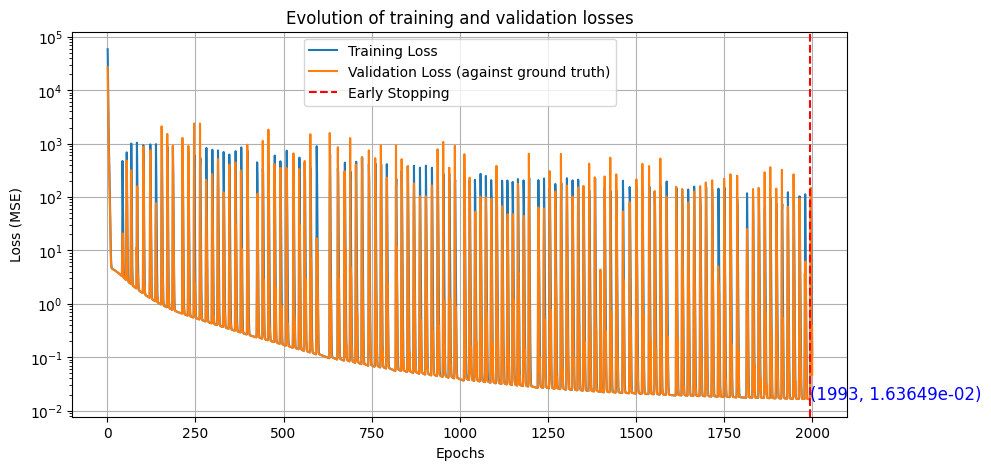

In [ ]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "swish"
epochs = 2000
patience = 150
start_from_epoch = 200
schedule_tg = 200
metrics = ["mse"]
opt = Adam(learning_rate=1e-3, weight_decay=1e-3)
batch = 16
alpha_d = 1
alpha_p = 1
alpha_b = 1
alpha = alpha_d, alpha_p, alpha_b #weights for different loss components
#------
#NN architecture
pinn_model = PinnModel()
pinn_model.add(Input(shape=(n_features, )))
for _ in range(0, n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(1, activation="linear")) #output layer -> a^

#Custom PINN loss
loss = CombinedLoss(car=car, model=pinn_model, X_c_norm=X_c_norm, scaler_X=scaler_X,
                    scaler_Y=None, loss_weights=alpha, x0_norm=x0_norm, y0=y0_true)
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_mse', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)

def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/pinn_model_forward.h5',
    monitor='val_mse', #track mse loss against true trajectory (not custom loss)
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

class CustomWeightLog(Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        for key, value in self.model.phy_trainable.items():
            logs[key] = value
    def on_train_end(self, logs=None):
        print(f"Custom trainable weights converged to:")
        for key, value in self.loss.train_params.items():
            true_value = self.model.phy_trainable_true[key]
            percentage = abs((value-true_value)/true_value)*100
            print(f"{key} = {value.numpy()}, true value = {true_value} ({percentage}% difference)")

custom_weight_logger = CustomWeightLog()

callbacks = [early_stopping, lr_scheduler, checkpoint, custom_weight_logger]
#callbacks = [lr_scheduler, checkpoint, custom_weight_logger] #removed ES 
#training
history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train,
                                  validation_data=(X_norm,Y_true), #validating against true values here, not measurements
                                  batch_size=batch, epochs=epochs,
                                  callbacks=callbacks, verbose=True)
loss_plot(history_pinn_fwd.history)

In [20]:
pinn_model.save("models/pinn_model_forward_best.h5")

# PUNN vs PINN

In [ ]:
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
custom_objects = {"PinnModel": PinnModel}
with with keras.saving.custom_object_scope(custom_objects):

pinn_model = load_model("models/pinn_model_forward_best.h5", compile=False)

true_data = df_train_traj[["a_true", "v_true_m", "x_true"]].to_numpy()
print("Training trajectory (" + str(train_id) + ") statistics: ")
print("PUNN:")
punn_train_traj_eval = evaluate_results(model=punn_model, X_norm=X_norm, true_data=true_data)
print("PINN:")
pinn_train_traj_eval = evaluate_results(model=pinn_model, X_norm=X_norm, true_data=true_data)
print("----")
comparison_plot(t=t, true_data=true_data, meas_data=Y_mask,
    pred_data=[(punn_train_traj_eval, "PUNN prediction"), (pinn_train_traj_eval, "PINN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + str(train_id)
)

true_data_test = df_test_traj[["a_true", "v_true_m", "x_true"]].to_numpy()
print("Testing trajectory (" + str(test_id) + ") statistics: ")
print("PUNN:")
punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=X_test_norm, true_data=true_data_test)
print("PINN:")
pinn_test_traj_eval = evaluate_results(model=pinn_model, X_norm=X_test_norm, true_data=true_data_test)
print("----")
comparison_plot(t=t, true_data=true_data_test, meas_data=None,
    pred_data=[(punn_test_traj_eval, "PUNN prediction"), (pinn_test_traj_eval, "PINN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory " + str(test_id)
)

ValueError: Unknown layer: 'PinnModel'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.